# Week 14 · Hyperparameter Sweep

**Goal**: Perform a full hyperparameter sweep on 5 models (4 subtype-specific + 1 aggregate) using 2-class LP with calculated contour.

**Hyperparameters**:
- `num_hid_units`: 32, 64
- `num_layers`: 2, 3
- `num_lags`: 4, 8
- `lr`: 1e-4, 5e-4
- `epochs`: 400 (fixed)

**Total**: 2 × 2 × 2 × 2 × 1 = 16 configurations × 5 model types = **80 models**

**Output**:
1. Best hyperparameters for each model type (selected on test data)
2. F1 barplot with per-video points and connecting lines
3. Flaring rate scatterplots (2 per fish type: type-specific vs aggregate)


In [1]:
from __future__ import annotations

import itertools
import json
import os
import shutil
from collections import defaultdict
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightning_action.api import Model
from sklearn.metrics import f1_score
import yaml

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# --- Paths & Configuration -------------------------------------------------
PROJECT_ROOT = Path("C:/Columbia Capstone")
DATA_ROOT = PROJECT_ROOT / "data_DLC&LP"
WEEK14_ROOT = PROJECT_ROOT / "Week 14"
WEEK12_ROOT = PROJECT_ROOT / "Week 12"

# Output directories
HPARAM_ROOT = WEEK14_ROOT / "hyperparameter_sweep"
HPARAM_ROOT.mkdir(parents=True, exist_ok=True)

MODELS_ROOT = HPARAM_ROOT / "models"
RESULTS_ROOT = HPARAM_ROOT / "results"
PLOTS_ROOT = HPARAM_ROOT / "plots"
BINARY_DATA_ROOT = HPARAM_ROOT / "binary_data"  # Preprocessed 2-class data (Week 12 style)

SEED = 43

# Fixed variant: LP with calculated contour (2-class)
VARIANT = "LP_with_cal_contour"
FEATURE_COUNT = 18  # LP with calculated contour has 18 features
OUTPUT_SIZE = 2  # 2-class (background vs flare)

# Model types: 4 subtype-specific + 1 aggregate
ALL_SUBTYPES = ["fighting", "hybrid", "ornamental", "wild"]
MODEL_TYPES = ALL_SUBTYPES + ["aggregate"]

# Hyperparameter grid
HPARAM_GRID = {
    "num_hid_units": [32, 64],
    "num_layers": [2, 3],
    "num_lags": [4, 8],
    "lr": [1e-4, 5e-4],
    "num_epochs": [400],  # Fixed
}

# Generate all hyperparameter combinations
HPARAM_COMBINATIONS = list(itertools.product(
    HPARAM_GRID["num_hid_units"],
    HPARAM_GRID["num_layers"],
    HPARAM_GRID["num_lags"],
    HPARAM_GRID["lr"],
    HPARAM_GRID["num_epochs"],
))

print(f"✓ Configuration loaded")
print(f"  Variant: {VARIANT} (2-class, {FEATURE_COUNT} features)")
print(f"  Model types: {len(MODEL_TYPES)} ({', '.join(MODEL_TYPES)})")
print(f"  Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"  Total models to train: {len(MODEL_TYPES) * len(HPARAM_COMBINATIONS)} = {len(MODEL_TYPES)} × {len(HPARAM_COMBINATIONS)}")


✓ Configuration loaded
  Variant: LP_with_cal_contour (2-class, 18 features)
  Model types: 5 (fighting, hybrid, ornamental, wild, aggregate)
  Hyperparameter combinations: 16
  Total models to train: 80 = 5 × 16


## Setup: Utility Functions

Functions for dataset loading, session validation, training, and evaluation.


In [12]:
# --- Utility Functions -----------------------------------------------------

@dataclass
class DatasetConfig:
    subtype: str
    variant: str
    path: Path
    feature_count: int
    input_dir: str = "features"
    feature_index: Dict[str, str] = field(default_factory=dict)
    label_index: Dict[str, str] = field(default_factory=dict)

    @property
    def features_dir(self) -> Path:
        return self.path / self.input_dir

    @property
    def labels_dir(self) -> Path:
        return self.path / "labels"

    @property
    def split_file(self) -> Path:
        return self.path / "splits.yaml"


def normalise_filename(name: str, subtype: str) -> str:
    """Normalize filename to canonical form."""
    if name.lower().endswith(".csv"):
        name = name[:-4]
    for suffix in ("_labels", "_labeled", "_featureonly", "_pure_feature"):
        if name.endswith(suffix):
            name = name[: -len(suffix)]
    
    # Handle aggregate identifiers (e.g., "fighting__1.2.2L")
    if "__" in name:
        return name
    
    token = name.split("_")[-1]
    if subtype == "ornamental" and token.startswith("orn"):
        token = token[3:]
    if subtype == "wild" and token.startswith("w") and not token.startswith("wxf"):
        token = token[1:]
    if subtype == "ornamental" and token.endswith("oR"):
        token = token[:-2] + "R"
    return token


def parse_splits(path: Path) -> Dict[str, List[str]]:
    """Parse splits.yaml file."""
    if not path.exists():
        raise FileNotFoundError(f"Missing splits file: {path}")
    current = None
    splits: Dict[str, List[str]] = {"train": [], "test": [], "val": []}
    for raw_line in path.read_text().splitlines():
        line = raw_line.split("#", 1)[0].strip()
        if not line:
            continue
        if line.endswith(":"):
            key = line[:-1].strip()
            current = key if key in splits else None
            continue
        if current and line.startswith("-"):
            value = line[1:].strip()
            if value:
                splits[current].append(value)
    return splits


def populate_signal_indices(config: DatasetConfig) -> None:
    """Populate feature and label indices from disk."""
    if not config.feature_index:
        for path in config.features_dir.glob("*.csv"):
            canonical = normalise_filename(path.name, config.subtype)
            config.feature_index.setdefault(canonical, path.stem)
    if not config.label_index:
        for path in config.labels_dir.glob("*.csv"):
            canonical = normalise_filename(path.name, config.subtype)
            config.label_index.setdefault(canonical, path.stem)


def validate_sessions(config: DatasetConfig, splits: Dict[str, List[str]]) -> Tuple[List[str], List[str]]:
    """Validate that all sessions in splits have corresponding feature and label files."""
    populate_signal_indices(config)
    
    SESSION_ALIASES = {
        "ornamental": {
            "2.7.1oR": "2.7.1R",
            "3.5.1oR": "3.5.1R",
        }
    }
    
    alias_map = SESSION_ALIASES.get(config.subtype, {})
    expected = set(splits["train"]) | set(splits["test"]) | set(splits["val"])
    
    missing_features: List[str] = []
    missing_labels: List[str] = []
    
    for session in expected:
        canonical = alias_map.get(session, session)
        # For aggregate, session might already be in format "fighting__1.2.2L"
        if config.subtype == "aggregate" and "__" in session:
            canonical = session
        else:
            canonical = normalise_filename(canonical, config.subtype)
        
        if canonical not in config.feature_index:
            missing_features.append(session)
        if canonical not in config.label_index:
            missing_labels.append(session)
    
    return sorted(missing_features), sorted(missing_labels)


def resolve_session_alias(session: str, subtype: str) -> str:
    """Resolve session alias to actual filename (e.g., '2.7.1oR' -> '2.7.1R' for ornamental)."""
    SESSION_ALIASES = {
        "ornamental": {
            "2.7.1oR": "2.7.1R",
            "3.5.1oR": "3.5.1R",
        }
    }
    alias_map = SESSION_ALIASES.get(subtype, {})
    return alias_map.get(session, session)


def load_dataset_config(model_type: str) -> DatasetConfig:
    """Load dataset configuration for a model type."""
    if model_type == "aggregate":
        # Aggregate dataset from Week 12
        path = WEEK12_ROOT / "aggregate_all" / VARIANT
        input_dir = "features"  # Aggregate uses features folder
    else:
        # Subtype-specific datasets
        # Week 12 style: all subtypes read from 'features' folder
        # The splits.yaml file determines which sessions are train/test
        if model_type == "fighting":
            base_path = DATA_ROOT / "new_data"
            variant_dir = "newLPwith_calculated_contour"
            input_dir = "features"  # Week 12 style: read from features folder
        elif model_type == "hybrid":
            base_path = DATA_ROOT / "new_hybrid" / "hybrid"
            variant_dir = "hybrid_LP_with_cal_contour"
            input_dir = "features"
        elif model_type == "ornamental":
            base_path = DATA_ROOT / "new_ornamental" / "ornamental"
            variant_dir = "ornamental_LP_with_cal_contour"
            input_dir = "features"
        elif model_type == "wild":
            base_path = DATA_ROOT / "new_wild" / "wild"
            variant_dir = "wild_LP_with_cal_contour"
            input_dir = "features"
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        path = base_path / variant_dir
    
    if not path.exists():
        raise FileNotFoundError(f"Dataset path not found: {path}")
    
    config = DatasetConfig(
        subtype=model_type,
        variant=VARIANT,
        path=path,
        feature_count=FEATURE_COUNT,
        input_dir=input_dir,  # All subtypes use 'features' folder (Week 12 style)
    )
    
    populate_signal_indices(config)
    return config


def create_config_dict(
    dataset: DatasetConfig,
    train_sessions: List[str],
    hparams: Tuple[int, int, int, float, int],
) -> Dict:
    """
    Create lightning-action configuration dictionary.
    Matches Week 12 pipeline configuration, with hyperparameters from hparams.
    
    Hyperparameters being searched:
    - num_hid_units: from hparams[0]
    - num_layers: from hparams[1]
    - num_lags: from hparams[2]
    - lr: from hparams[3]
    - num_epochs: from hparams[4]
    
    All other parameters match Week 12 defaults.
    """
    # Resolve session aliases (e.g., "2.7.1oR" -> "2.7.1R" for ornamental)
    # For aggregate, we need to check all subtype aliases since it contains sessions from all subtypes
    SESSION_ALIASES = {
        "ornamental": {
            "2.7.1oR": "2.7.1R",
            "3.5.1oR": "3.5.1R",
        }
    }
    
    # For aggregate, check all subtype aliases; for specific subtypes, only check that subtype's aliases
    if dataset.subtype == "aggregate":
        # Merge all alias maps for aggregate
        all_aliases = {}
        for subtype_aliases in SESSION_ALIASES.values():
            all_aliases.update(subtype_aliases)
        alias_map = all_aliases
    else:
        alias_map = SESSION_ALIASES.get(dataset.subtype, {})
    
    resolved_sessions = [alias_map.get(session, session) for session in train_sessions]
    
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    sequence_pad = sum([2 * (2 ** n) * num_lags for n in range(num_layers)])
    config = {
        "data": {
            "data_path": str(dataset.path),
            "input_dir": dataset.input_dir,
            "transforms": ["ZScore"],
            "expt_ids": resolved_sessions,
            "seed": SEED,
            "ignore_index": -100,
            "weight_classes": True,
            "label_names": ["background", "flare"],
        },
        "model": {
            "input_size": dataset.feature_count,
            "output_size": OUTPUT_SIZE,
            "backbone": "dtcn",
            "num_hid_units": num_hid_units,  # From hyperparameter search
            "num_layers": num_layers,  # From hyperparameter search
            "num_lags": num_lags,  # From hyperparameter search
            "sequence_pad": sequence_pad,
            "seed": SEED,
        },
        "optimizer": {
            "type": "Adam",
            "lr": lr,  # From hyperparameter search
            "wd": 0,
            "scheduler": None,
        },
        "training": {
            "device": "gpu",
            "num_epochs": num_epochs,  # From hyperparameter search (400)
            "batch_size": 16,  # Week 12 default
            "num_workers": 4,
            "sequence_length": 1000,
            "train_probability": 0.95,  # Week 12 default
            "val_probability": 0.05,  # Week 12 default
        },
    }
    return config


def save_results(model_type: str, results: Dict) -> None:
    """Save results to JSON file."""
    results_path = RESULTS_ROOT / f"{model_type}_results.json"
    results_path.parent.mkdir(parents=True, exist_ok=True)
    with open(results_path, "w") as f:
        json.dump(results, f, indent=2, default=str)
    print(f"✓ Results saved to {results_path}")


def load_results(model_type: str) -> Optional[Dict]:
    """Load results from JSON file if exists."""
    results_path = RESULTS_ROOT / f"{model_type}_results.json"
    if results_path.exists():
        with open(results_path, "r") as f:
            return json.load(f)
    return None


# Week 12 style: Data preprocessing functions (no monkey patches)
def convert_labels_to_binary(label_path: Path) -> pd.DataFrame:
    """Convert 3-class labels to binary (flare vs background). Same as Week 12."""
    df = pd.read_csv(label_path)
    columns = df.columns.tolist()
    index_col = columns[0]
    if {"full_flaring", "half_flaring"}.issubset(columns):
        flare = ((df["full_flaring"] > 0) | (df["half_flaring"] > 0)).astype(int)
    else:
        class_col = columns[-1]
        flare = (df[class_col] > 0).astype(int)
    background = 1 - flare
    return pd.DataFrame({index_col: df[index_col], "background": background, "flare": flare})


def prepare_binary_dataset(cfg: DatasetConfig) -> DatasetConfig:
    """Prepare binary dataset from 3-class dataset.
    统一放入 features/ + labels/，所有 subtype 一致；train/test 用 splits.yaml 控制。
    """
    target_root = BINARY_DATA_ROOT / cfg.subtype / cfg.variant
    if target_root.exists():
        shutil.rmtree(target_root)
    (target_root / "features").mkdir(parents=True, exist_ok=True)
    (target_root / "labels").mkdir(parents=True, exist_ok=True)

    # Copy all feature CSVs into features/
    # 若源有 training/test，也会被 glob("*.csv") 覆盖全部；保持简单一致
    for file in cfg.path.rglob("*.csv"):
        # 只拷贝特征，不拷贝标签；标签在下方转换写入
        if file.parent.name.lower() == "labels":
            continue
        shutil.copy(file, target_root / "features" / file.name)

    # Convert and save labels
    for label_file in cfg.labels_dir.glob("*.csv"):
        binary_df = convert_labels_to_binary(label_file)
        binary_df.to_csv(target_root / "labels" / label_file.name, index=False)

    # Copy splits file
    shutil.copy(cfg.split_file, target_root / "splits.yaml")

    return DatasetConfig(
        subtype=cfg.subtype,
        variant=cfg.variant,
        path=target_root,
        feature_count=cfg.feature_count,
        input_dir="features",
    )

print("✓ Utility functions defined")
print("✓ Data preprocessing functions ready (Week 12 style, no monkey patches)")


✓ Utility functions defined
✓ Data preprocessing functions ready (Week 12 style, no monkey patches)


In [4]:
# --- Binary F1 helper (Week10-style) ---------------------------------------

def extract_binary_labels_and_preds(pred_df, label_df, positive_col="flare"):
    """
    统一把各种格式的 prediction / label DataFrame 转成 0/1（flare vs non-flare）。
    返回: (labels, preds)，如果长度为 0 则返回 (None, None)。
    """
    length = min(len(pred_df), len(label_df))
    if length == 0:
        return None, None

    pred_df = pred_df.iloc[:length]
    label_df = label_df.iloc[:length]

    # === 预测：优先 [background, flare] → predicted → flare → 兜底一列 ===
    if {"background", positive_col}.issubset(pred_df.columns):
        scores = pred_df[["background", positive_col]].values
        preds = scores.argmax(axis=1)
    elif "predicted" in pred_df.columns:
        vals = pred_df["predicted"].values
        uniq = np.unique(vals[~pd.isna(vals)])
        if set(uniq).issubset({0, 1}):
            preds = vals.astype(int)
        else:
            preds = (vals > 0).astype(int)
    elif positive_col in pred_df.columns:
        scores = pred_df[positive_col].values
        min_v, max_v = np.nanmin(scores), np.nanmax(scores)
        thresh = 0.5 if (0.0 <= min_v <= 1.0 and 0.0 <= max_v <= 1.0) else 0.0
        preds = (scores > thresh).astype(int)
    else:
        scores = pred_df.iloc[:, -1].values
        min_v, max_v = np.nanmin(scores), np.nanmax(scores)
        thresh = 0.5 if (0.0 <= min_v <= 1.0 and 0.0 <= max_v <= 1.0) else 0.0
        preds = (scores > thresh).astype(int)

    # === 标签：优先 [background, flare] → flare → 兜底一列 ===
    if {"background", positive_col}.issubset(label_df.columns):
        scores = label_df[["background", positive_col]].values
        labels = scores.argmax(axis=1)
    elif positive_col in label_df.columns:
        labels = (label_df[positive_col].values > 0).astype(int)
    else:
        labels = (label_df.iloc[:, -1].values > 0).astype(int)

    return labels, preds

## Step 1: Load and Validate Datasets

Load all dataset configurations and validate that all sessions are available.


In [5]:
# Load all dataset configurations
dataset_configs = {}

for model_type in MODEL_TYPES:
    try:
        config = load_dataset_config(model_type)
        splits = parse_splits(config.split_file)
        missing_feat, missing_lab = validate_sessions(config, splits)
        
        if missing_feat or missing_lab:
            print(f"⚠ {model_type:12s}: Missing features={missing_feat}, Missing labels={missing_lab}")
        else:
            print(f"✓ {model_type:12s}: {len(splits['train'])} train, {len(splits['test'])} test, {len(splits['val'])} val")
            dataset_configs[model_type] = config
            
            # Check data file length consistency for first few sessions
            if model_type == "fighting":  # Only check fighting for now
                print(f"\n  Checking data file lengths for {model_type}...")
                all_sessions = splits['train'] + splits['test']
                for session in all_sessions[:3]:  # Check first 3 sessions
                    try:
                        feat_file = config.features_dir / f"{session}.csv"
                        label_file = config.labels_dir / f"{session}.csv"
                        if not feat_file.exists():
                            canonical = normalise_filename(session, model_type)
                            feat_stem = config.feature_index.get(canonical, canonical)
                            feat_file = config.features_dir / f"{feat_stem}.csv"
                        if not label_file.exists():
                            canonical = normalise_filename(session, model_type)
                            label_stem = config.label_index.get(canonical, canonical)
                            label_file = config.labels_dir / f"{label_stem}.csv"
                        
                        if feat_file.exists() and label_file.exists():
                            feat_df = pd.read_csv(feat_file, index_col=0)
                            label_df = pd.read_csv(label_file, index_col=0)
                            match = feat_df.shape[0] == label_df.shape[0]
                            status = "✓" if match else "✗"
                            print(f"    {status} {session:15s}: feat={feat_df.shape[0]:6d}, label={label_df.shape[0]:6d}, match={match}")
                            
                            # Additional check: verify sequence count calculation
                            if not match:
                                seq_len = 1000
                                feat_seqs = int(feat_df.shape[0] / seq_len)
                                label_seqs = int(label_df.shape[0] / seq_len)
                                print(f"      -> feat sequences: {feat_seqs}, label sequences: {label_seqs}")
                                print(f"      -> feat remainder: {feat_df.shape[0] % seq_len}, label remainder: {label_df.shape[0] % seq_len}")
                    except Exception as e:
                        print(f"    ✗ {session:15s}: Error checking - {e}")
    except Exception as e:
        print(f"✗ {model_type:12s}: Error - {e}")

print(f"\n✓ Loaded {len(dataset_configs)} dataset configurations")


✓ fighting    : 9 train, 7 test, 0 val

  Checking data file lengths for fighting...
    ✓ 1.1.28R        : feat= 72000, label= 72000, match=True
    ✓ 1.1.28L        : feat= 72000, label= 72000, match=True
    ✓ 1.2.2R         : feat= 72000, label= 72000, match=True
✓ hybrid      : 15 train, 5 test, 0 val
✓ ornamental  : 17 train, 5 test, 0 val
✓ wild        : 14 train, 5 test, 0 val
✓ aggregate   : 55 train, 22 test, 0 val

✓ Loaded 5 dataset configurations


## Step 2: Training - Subtype-Specific Models

Each subtype has 2 cells:
1. **Training Cell**: Train all 16 hyperparameter combinations
2. **Inference Cell**: Run inference on test sessions and evaluate

### Fighting Subtype - Training


In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

def calculate_binary_metrics_per_session(predictions_dir, dataset_config, test_sessions):
    """Calculate flare/background F1 scores for binary models. (Week10 style)"""
    results = []
    data_path = Path(dataset_config["data_path"])
    labels_dir = data_path / "labels"

    for session in test_sessions:
        pred_file = predictions_dir / f"{session}_predictions.csv"
        if not pred_file.exists():
            print(f"  ⚠️  Prediction file not found for session {session}")
            continue

        gt_file = labels_dir / f"{session}.csv"
        if not gt_file.exists():
            print(f"  ⚠️  Ground truth file not found for session {session}")
            continue

        pred_df = pd.read_csv(pred_file)
        gt_df = pd.read_csv(gt_file)

        # 对齐长度
        min_len = min(len(pred_df), len(gt_df))
        pred_df = pred_df.iloc[:min_len]
        gt_df = gt_df.iloc[:min_len]

        # 预测 → 0/1
        if {"background", "flare"}.issubset(pred_df.columns):
            predictions = np.argmax(pred_df[["background", "flare"]].values, axis=1)
        elif "predicted" in pred_df.columns:
            predictions = (pred_df["predicted"].astype(int) > 0).astype(int).values
        else:
            print(f"  ⚠️  Unknown prediction format for {session}")
            continue

        # 标签 → 0/1
        if {"background", "flare"}.issubset(gt_df.columns):
            ground_truth = np.argmax(gt_df[["background", "flare"]].values, axis=1)
        else:
            ground_truth = (gt_df.iloc[:, -1].astype(int) > 0).astype(int).values

        f1_flare = f1_score(ground_truth, predictions, average="binary")
        flare_rate = ground_truth.mean()

        results.append(
            {
                "session": session,
                "flare_f1": f1_flare,
                "flare_rate": flare_rate,
            }
        )

    return results

In [7]:
# Fighting Subtype - Training
# Train all 16 hyperparameter combinations

MODEL_TYPE = "fighting"

# Load previous results if exists (allows resuming after crash)
results = load_results(MODEL_TYPE) or {}

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Preprocess data to 2-class before training
raw_dataset = dataset_configs[MODEL_TYPE]
print(f"Preprocessing {MODEL_TYPE} dataset to 2-class (Week 12 style)...")
binary_dataset = prepare_binary_dataset(raw_dataset)
print(f"✓ Preprocessed data saved to: {binary_dataset.path}")

splits = parse_splits(binary_dataset.split_file)
dataset = binary_dataset  # Use preprocessed dataset for training

print(f"{'='*80}")
print(f"TRAINING: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Train sessions: {len(splits['train'])}")
print(f"Test sessions: {len(splits['test'])}")
print(f"Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already trained
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    if (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already trained")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Training...")
    
    try:
        config = create_config_dict(dataset, splits["train"], hparams)
        
        # Save config
        config_path = model_dir / "config.yaml"
        config_path.parent.mkdir(parents=True, exist_ok=True)
        with open(config_path, "w") as f:
            yaml.dump(config, f, default_flow_style=False)
        
        # Train model
        # Week 10 style: pass config file path instead of dict
        # This ensures Model.from_config loads the config fresh and handles sequence_pad correctly
        model = Model.from_config(str(config_path))
        model.train(output_dir=str(model_dir))
        
        print(f"    ✓ Training completed")
        
    except Exception as e:
        print(f"    ✗ Training failed: {e}")
        continue

# Save progress
results["training_completed"] = True
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Training completed for {MODEL_TYPE}")
print(f"{'='*80}")


Preprocessing fighting dataset to 2-class (Week 12 style)...


Seed set to 43


✓ Preprocessed data saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
TRAINING: FIGHTING SUBTYPE
Train sessions: 9
Test sessions: 7
Hyperparameter combinations: 16

[ 1/16] nh32_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

--------------------
model parameters
--------------------
backbone: dtcn
input_size: 18
num_hid_units: 32
num_lags: 4
num_layers: 2
output_size: 2
se

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
---------

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 35.75it/s, val_loss=0.245, val_accuracy=0.919, val_f1=0.919, train_loss=0.188, train_accuracy=0.921, train_f1=0.921]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 35.61it/s, val_loss=0.245, val_accuracy=0.919, val_f1=0.919, train_loss=0.188, train_accuracy=0.921, train_f1=0.921]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 2/16] nh32_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 38.37it/s, val_loss=0.253, val_accuracy=0.917, val_f1=0.917, train_loss=0.138, train_accuracy=0.941, train_f1=0.941]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 38.24it/s, val_loss=0.253, val_accuracy=0.917, val_f1=0.917, train_loss=0.138, train_accuracy=0.941, train_f1=0.941]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 3/16] nh32_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:00<00:00, 44.47it/s, val_loss=0.267, val_accuracy=0.933, val_f1=0.933, train_loss=0.145, train_accuracy=0.938, train_f1=0.938]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:00<00:00, 44.31it/s, val_loss=0.267, val_accuracy=0.933, val_f1=0.933, train_loss=0.145, train_accuracy=0.938, train_f1=0.938]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 4/16] nh32_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:00<00:00, 42.99it/s, val_loss=0.438, val_accuracy=0.936, val_f1=0.936, train_loss=0.103, train_accuracy=0.956, train_f1=0.956]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:00<00:00, 42.85it/s, val_loss=0.438, val_accuracy=0.936, val_f1=0.936, train_loss=0.103, train_accuracy=0.956, train_f1=0.956]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 5/16] nh32_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.92it/s, val_loss=0.268, val_accuracy=0.930, val_f1=0.930, train_loss=0.147, train_accuracy=0.937, train_f1=0.937]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.87it/s, val_loss=0.268, val_accuracy=0.930, val_f1=0.930, train_loss=0.147, train_accuracy=0.937, train_f1=0.937]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 6/16] nh32_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 26.93it/s, val_loss=0.330, val_accuracy=0.943, val_f1=0.943, train_loss=0.096, train_accuracy=0.958, train_f1=0.958] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 26.88it/s, val_loss=0.330, val_accuracy=0.943, val_f1=0.943, train_loss=0.096, train_accuracy=0.958, train_f1=0.958]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 7/16] nh32_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 28.22it/s, val_loss=0.426, val_accuracy=0.930, val_f1=0.930, train_loss=0.119, train_accuracy=0.948, train_f1=0.948]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 28.15it/s, val_loss=0.426, val_accuracy=0.930, val_f1=0.930, train_loss=0.119, train_accuracy=0.948, train_f1=0.948]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 8/16] nh32_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 26.69it/s, val_loss=0.533, val_accuracy=0.937, val_f1=0.937, train_loss=0.0784, train_accuracy=0.966, train_f1=0.966]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 26.62it/s, val_loss=0.533, val_accuracy=0.937, val_f1=0.937, train_loss=0.0784, train_accuracy=0.966, train_f1=0.966]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 9/16] nh64_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 31.69it/s, val_loss=0.281, val_accuracy=0.926, val_f1=0.926, train_loss=0.133, train_accuracy=0.945, train_f1=0.945]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 31.62it/s, val_loss=0.281, val_accuracy=0.926, val_f1=0.926, train_loss=0.133, train_accuracy=0.945, train_f1=0.945]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[10/16] nh64_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 28.04it/s, val_loss=0.417, val_accuracy=0.929, val_f1=0.929, train_loss=0.0891, train_accuracy=0.963, train_f1=0.963]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.98it/s, val_loss=0.417, val_accuracy=0.929, val_f1=0.929, train_loss=0.0891, train_accuracy=0.963, train_f1=0.963]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[11/16] nh64_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.42it/s, val_loss=0.391, val_accuracy=0.933, val_f1=0.933, train_loss=0.0931, train_accuracy=0.960, train_f1=0.960]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.37it/s, val_loss=0.391, val_accuracy=0.933, val_f1=0.933, train_loss=0.0931, train_accuracy=0.960, train_f1=0.960]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[12/16] nh64_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.23it/s, val_loss=0.494, val_accuracy=0.934, val_f1=0.934, train_loss=0.0598, train_accuracy=0.975, train_f1=0.975]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:01<00:00, 27.16it/s, val_loss=0.494, val_accuracy=0.934, val_f1=0.934, train_loss=0.0598, train_accuracy=0.975, train_f1=0.975]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[13/16] nh64_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 15.92it/s, val_loss=0.300, val_accuracy=0.940, val_f1=0.940, train_loss=0.102, train_accuracy=0.955, train_f1=0.955] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 15.90it/s, val_loss=0.300, val_accuracy=0.940, val_f1=0.940, train_loss=0.102, train_accuracy=0.955, train_f1=0.955]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[14/16] nh64_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 13.39it/s, val_loss=0.557, val_accuracy=0.940, val_f1=0.940, train_loss=0.0568, train_accuracy=0.976, train_f1=0.976]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 13.38it/s, val_loss=0.557, val_accuracy=0.940, val_f1=0.940, train_loss=0.0568, train_accuracy=0.976, train_f1=0.976]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[15/16] nh64_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 13.61it/s, val_loss=0.519, val_accuracy=0.936, val_f1=0.936, train_loss=0.067, train_accuracy=0.972, train_f1=0.972] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 13.59it/s, val_loss=0.519, val_accuracy=0.936, val_f1=0.936, train_loss=0.067, train_accuracy=0.972, train_f1=0.972]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.1.28R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[16/16] nh64_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
expt_ids: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

-------

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 15.59it/s, val_loss=0.679, val_accuracy=0.941, val_f1=0.941, train_loss=0.0375, train_accuracy=0.984, train_f1=0.984]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 39/39 [00:02<00:00, 15.56it/s, val_loss=0.679, val_accuracy=0.941, val_f1=0.941, train_loss=0.0375, train_accuracy=0.984, train_f1=0.984]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\fighting\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.1.28R', '1.1.28L', '1.2.2R', '1.2.28R', '1.3.1R', '1.4.1R', '2.1.28L', '3.1.28L', '3.2.28L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.1.28R_predictions.csv
Generating predictions for experiment: 1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.1.28L_predictions.csv
Generating predictions for experiment: 1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.2.2R_predictions.csv
Generating predictions for experiment: 1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.2.28R_predictions.csv
Generating predictions for experiment: 1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.3.1R_predictions.csv
Generating predictions for experiment: 1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.4.1R_predictions.csv
Generating predictions for experiment: 2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\2.1.28L_predictions.csv
Generating predictions for experiment: 3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\3.1.28L_predictions.csv
Generating predictions for experiment: 3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\3.2.28L_predictions.csv
Completed predictions for 9 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\fighting_results.json

✓ Training completed for fighting


### Fighting Subtype - Inference & Evaluation


In [8]:
# Fighting Subtype - Inference & Evaluation
# Run inference on test sessions and compute F1 scores

MODEL_TYPE = "fighting"

# Load previous results
results = load_results(MODEL_TYPE) or {}
results.setdefault("hparam_results", {})

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Use preprocessed 2-class data
raw_dataset = dataset_configs[MODEL_TYPE]
binary_dataset = DatasetConfig(
    subtype=raw_dataset.subtype,
    variant=raw_dataset.variant,
    path=BINARY_DATA_ROOT / raw_dataset.subtype / raw_dataset.variant,
    feature_count=raw_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(binary_dataset)

dataset = binary_dataset  # Use preprocessed dataset for inference
splits = parse_splits(dataset.split_file)

print(f"{'='*80}")
print(f"INFERENCE & EVALUATION: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    
    # Skip if already evaluated
    if hparam_key in results["hparam_results"]:
        f1 = results["hparam_results"][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    if not (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load model
        model = Model.from_dir(str(model_dir))
        
        # Run predictions
        pred_dir = model_dir / "predictions"
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in splits["test"]:
            model.predict(
                data_path=str(dataset.path),
                input_dir=dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        per_session_f1 = {}
        
        for session in splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, MODEL_TYPE)
                feat_stem = dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, MODEL_TYPE)
                label_stem = dataset.label_index.get(canonical, canonical)
                label_file = dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            # 统一用 Week10 风格把 CSV 转成 0/1，再算 F1
            labels, preds = extract_binary_labels_and_preds(pred_df, label_df, positive_col="flare")
            if labels is None:
                continue
            
            session_f1 = f1_score(labels, preds, average="binary")
            per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        results["hparam_results"][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Inference & evaluation completed for {MODEL_TYPE}")
print(f"{'='*80}")

Seed set to 43


INFERENCE & EVALUATION: FIGHTING SUBTYPE
Test sessions: 7

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...


Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=352-step=13767-best.ckpt
Generating predictions for experiment: 1.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6768
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=132-step=5187-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg4_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6934
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=276-step=10803-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7008
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=84-step=3315-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly2_lg8_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7149
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=262-step=10257-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6907
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=81-step=3198-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg4_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6993
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=129-step=5070-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7005
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=10-step=429-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh32_ly3_lg8_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7095
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=221-step=8658-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6827
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=125-step=4914-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg4_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6780
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=81-step=3198-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7129
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=58-step=2301-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly2_lg8_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7027
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=139-step=5460-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7021
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=83-step=3276-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg4_lr5e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7070
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=56-step=2223-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr1e-04\predictions


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6844
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=31-step=1248-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\fighting\nh64_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.7279
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\fighting_results.json

✓ Inference & evaluation completed for fighting


### Hybrid Subtype - Training


In [9]:
# Hybrid Subtype - Training
# Train all 16 hyperparameter combinations

MODEL_TYPE = "hybrid"

# Load previous results if exists (allows resuming after crash)
results = load_results(MODEL_TYPE) or {}

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Preprocess data to 2-class before training
raw_dataset = dataset_configs[MODEL_TYPE]
print(f"Preprocessing {MODEL_TYPE} dataset to 2-class (Week 12 style)...")
binary_dataset = prepare_binary_dataset(raw_dataset)
print(f"✓ Preprocessed data saved to: {binary_dataset.path}")

splits = parse_splits(binary_dataset.split_file)
dataset = binary_dataset  # Use preprocessed dataset for training

print(f"{'='*80}")
print(f"TRAINING: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Train sessions: {len(splits['train'])}")
print(f"Test sessions: {len(splits['test'])}")
print(f"Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already trained
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    if (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already trained")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Training...")
    
    try:
        config = create_config_dict(dataset, splits["train"], hparams)
        
        # Save config
        config_path = model_dir / "config.yaml"
        config_path.parent.mkdir(parents=True, exist_ok=True)
        with open(config_path, "w") as f:
            yaml.dump(config, f, default_flow_style=False)
        
        # Train model
        # Week 10/12 style: pass config file path instead of dict
        # This ensures Model.from_config loads the config fresh and handles sequence_pad correctly
        model = Model.from_config(str(config_path))
        model.train(output_dir=str(model_dir))
        
        print(f"    ✓ Training completed")
        
    except Exception as e:
        print(f"    ✗ Training failed: {e}")
        continue

# Save progress
results["training_completed"] = True
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Training completed for {MODEL_TYPE}")
print(f"{'='*80}")


Preprocessing hybrid dataset to 2-class (Week 12 style)...


Seed set to 43


✓ Preprocessed data saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
TRAINING: HYBRID SUBTYPE
Train sessions: 15
Test sessions: 5
Hyperparameter combinations: 16

[ 1/16] nh32_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

--------------------
model parameters
--------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 31.75it/s, val_loss=0.314, val_accuracy=0.952, val_f1=0.952, train_loss=0.0782, train_accuracy=0.968, train_f1=0.968]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 31.61it/s, val_loss=0.314, val_accuracy=0.952, val_f1=0.952, train_loss=0.0782, train_accuracy=0.968, train_f1=0.968]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 2/16] nh32_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 32.00it/s, val_loss=0.435, val_accuracy=0.958, val_f1=0.958, train_loss=0.0425, train_accuracy=0.982, train_f1=0.982]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 31.84it/s, val_loss=0.435, val_accuracy=0.958, val_f1=0.958, train_loss=0.0425, train_accuracy=0.982, train_f1=0.982]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 3/16] nh32_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 33.58it/s, val_loss=0.498, val_accuracy=0.949, val_f1=0.949, train_loss=0.0531, train_accuracy=0.976, train_f1=0.976]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 33.42it/s, val_loss=0.498, val_accuracy=0.949, val_f1=0.949, train_loss=0.0531, train_accuracy=0.976, train_f1=0.976]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 4/16] nh32_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 32.54it/s, val_loss=0.441, val_accuracy=0.947, val_f1=0.947, train_loss=0.0367, train_accuracy=0.983, train_f1=0.983]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 32.41it/s, val_loss=0.441, val_accuracy=0.947, val_f1=0.947, train_loss=0.0367, train_accuracy=0.983, train_f1=0.983]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 5/16] nh32_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 19.38it/s, val_loss=0.298, val_accuracy=0.961, val_f1=0.961, train_loss=0.0631, train_accuracy=0.971, train_f1=0.971]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 19.32it/s, val_loss=0.298, val_accuracy=0.961, val_f1=0.961, train_loss=0.0631, train_accuracy=0.971, train_f1=0.971]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 6/16] nh32_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 20.04it/s, val_loss=0.508, val_accuracy=0.952, val_f1=0.952, train_loss=0.0325, train_accuracy=0.985, train_f1=0.985]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 19.98it/s, val_loss=0.508, val_accuracy=0.952, val_f1=0.952, train_loss=0.0325, train_accuracy=0.985, train_f1=0.985]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 7/16] nh32_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 20.45it/s, val_loss=0.644, val_accuracy=0.957, val_f1=0.957, train_loss=0.0393, train_accuracy=0.982, train_f1=0.982]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 20.39it/s, val_loss=0.644, val_accuracy=0.957, val_f1=0.957, train_loss=0.0393, train_accuracy=0.982, train_f1=0.982]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 8/16] nh32_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 20.37it/s, val_loss=0.728, val_accuracy=0.957, val_f1=0.957, train_loss=0.0195, train_accuracy=0.991, train_f1=0.991]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 20.32it/s, val_loss=0.728, val_accuracy=0.957, val_f1=0.957, train_loss=0.0195, train_accuracy=0.991, train_f1=0.991]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 9/16] nh64_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 21.40it/s, val_loss=0.356, val_accuracy=0.957, val_f1=0.957, train_loss=0.0423, train_accuracy=0.981, train_f1=0.981]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 21.32it/s, val_loss=0.356, val_accuracy=0.957, val_f1=0.957, train_loss=0.0423, train_accuracy=0.981, train_f1=0.981]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[10/16] nh64_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 24.09it/s, val_loss=0.609, val_accuracy=0.949, val_f1=0.949, train_loss=0.0237, train_accuracy=0.989, train_f1=0.989]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 23.99it/s, val_loss=0.609, val_accuracy=0.949, val_f1=0.949, train_loss=0.0237, train_accuracy=0.989, train_f1=0.989]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[11/16] nh64_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 23.36it/s, val_loss=0.317, val_accuracy=0.947, val_f1=0.947, train_loss=0.0307, train_accuracy=0.987, train_f1=0.987]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 23.28it/s, val_loss=0.317, val_accuracy=0.947, val_f1=0.947, train_loss=0.0307, train_accuracy=0.987, train_f1=0.987]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[12/16] nh64_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 24.13it/s, val_loss=0.960, val_accuracy=0.948, val_f1=0.948, train_loss=0.0163, train_accuracy=0.992, train_f1=0.992]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:00<00:00, 24.04it/s, val_loss=0.960, val_accuracy=0.948, val_f1=0.948, train_loss=0.0163, train_accuracy=0.992, train_f1=0.992]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[13/16] nh64_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s, val_loss=0.663, val_accuracy=0.960, val_f1=0.960, train_loss=0.0282, train_accuracy=0.986, train_f1=0.986]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.92it/s, val_loss=0.663, val_accuracy=0.960, val_f1=0.960, train_loss=0.0282, train_accuracy=0.986, train_f1=0.986]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[14/16] nh64_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 13.01it/s, val_loss=0.586, val_accuracy=0.962, val_f1=0.962, train_loss=0.0129, train_accuracy=0.994, train_f1=0.994]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.97it/s, val_loss=0.586, val_accuracy=0.962, val_f1=0.962, train_loss=0.0129, train_accuracy=0.994, train_f1=0.994]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[15/16] nh64_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.89it/s, val_loss=0.956, val_accuracy=0.958, val_f1=0.958, train_loss=0.0183, train_accuracy=0.992, train_f1=0.992]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.86it/s, val_loss=0.956, val_accuracy=0.958, val_f1=0.958, train_loss=0.0183, train_accuracy=0.992, train_f1=0.992]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[16/16] nh64_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
expt_ids: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
ignore_index: -100
input_dir: features
label_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.93it/s, val_loss=0.943, val_accuracy=0.960, val_f1=0.960, train_loss=0.0108, train_accuracy=0.995, train_f1=0.995] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 22/22 [00:01<00:00, 12.90it/s, val_loss=0.943, val_accuracy=0.960, val_f1=0.960, train_loss=0.0108, train_accuracy=0.995, train_f1=0.995]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\hybrid\LP_with_cal_contour
Input directory: features
Experiment IDs: ['RHT3.3.1R', 'RHT4.3.1L', 'RHT5.10.1R', 'RHT6.2.2L', 'RHT2.3.1L', 'RHT9.8.1R', 'wxf1.2.2R', 'wxf1.3.1L', 'wxf1.5.1R', 'wxf2.10.1R', 'wxf3.3.1R', 'wxf4.3.1L', 'wxf5180R', 'wxf5239R', 'wxf5272L']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT3.3.1R_predictions.csv
Generating predictions for experiment: RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT4.3.1L_predictions.csv
Generating predictions for experiment: RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT5.10.1R_predictions.csv
Generating predictions for experiment: RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT6.2.2L_predictions.csv
Generating predictions for experiment: RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT2.3.1L_predictions.csv
Generating predictions for experiment: RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT9.8.1R_predictions.csv
Generating predictions for experiment: wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf1.2.2R_predictions.csv
Generating predictions for experiment: wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf1.3.1L_predictions.csv
Generating predictions for experiment: wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf1.5.1R_predictions.csv
Generating predictions for experiment: wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf2.10.1R_predictions.csv
Generating predictions for experiment: wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf3.3.1R_predictions.csv
Generating predictions for experiment: wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf4.3.1L_predictions.csv
Generating predictions for experiment: wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf5180R_predictions.csv
Generating predictions for experiment: wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf5239R_predictions.csv
Generating predictions for experiment: wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf5272L_predictions.csv
Completed predictions for 15 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\hybrid_results.json

✓ Training completed for hybrid


### Hybrid Subtype - Inference & Evaluation


In [10]:
# Hybrid Subtype - Inference & Evaluation
# Run inference on test sessions and compute F1 scores

MODEL_TYPE = "hybrid"

# Load previous results
results = load_results(MODEL_TYPE) or {}
results.setdefault("hparam_results", {})

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Use preprocessed 2-class data
raw_dataset = dataset_configs[MODEL_TYPE]
binary_dataset = DatasetConfig(
    subtype=raw_dataset.subtype,
    variant=raw_dataset.variant,
    path=BINARY_DATA_ROOT / raw_dataset.subtype / raw_dataset.variant,
    feature_count=raw_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(binary_dataset)

dataset = binary_dataset  # Use preprocessed dataset for inference
splits = parse_splits(dataset.split_file)

print(f"{'='*80}")
print(f"INFERENCE & EVALUATION: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    
    # Skip if already evaluated
    if hparam_key in results["hparam_results"]:
        f1 = results["hparam_results"][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    if not (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load model
        model = Model.from_dir(str(model_dir))
        
        # Run predictions
        pred_dir = model_dir / "predictions"
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in splits["test"]:
            model.predict(
                data_path=str(dataset.path),
                input_dir=dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, MODEL_TYPE)
                feat_stem = dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, MODEL_TYPE)
                label_stem = dataset.label_index.get(canonical, canonical)
                label_file = dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        results["hparam_results"][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Inference & evaluation completed for {MODEL_TYPE}")
print(f"{'='*80}")


Seed set to 43


Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFERENCE & EVALUATION: HYBRID SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=385-step=8492-best.ckpt
Generating predictions for experiment: RHT2.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.6295
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=82-step=1826-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5997
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=103-step=2288-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.6304
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=103-step=2288-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.6376
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=233-step=5148-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.6333
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=43-step=968-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.5939
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=80-step=1782-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.6377
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=134-step=2970-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh32_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.6511
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=113-step=2508-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.6003
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=36-step=814-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5933
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=115-step=2552-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.6312
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=46-step=1034-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.6302
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=73-step=1628-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.6143
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=28-step=638-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.6166
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=46-step=1034-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.6305
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=14-step=330-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\hybrid\nh64_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.5875
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\hybrid_results.json

✓ Inference & evaluation completed for hybrid


### Ornamental Subtype - Training


In [11]:
# Ornamental Subtype - Training
# Train all 16 hyperparameter combinations

MODEL_TYPE = "ornamental"

# Load previous results if exists (allows resuming after crash)
results = load_results(MODEL_TYPE) or {}

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Preprocess data to 2-class before training
raw_dataset = dataset_configs[MODEL_TYPE]
print(f"Preprocessing {MODEL_TYPE} dataset to 2-class (Week 12 style)...")
binary_dataset = prepare_binary_dataset(raw_dataset)
print(f"✓ Preprocessed data saved to: {binary_dataset.path}")

splits = parse_splits(binary_dataset.split_file)
dataset = binary_dataset  # Use preprocessed dataset for training

print(f"{'='*80}")
print(f"TRAINING: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Train sessions: {len(splits['train'])}")
print(f"Test sessions: {len(splits['test'])}")
print(f"Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already trained
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    if (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already trained")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Training...")
    
    try:
        config = create_config_dict(dataset, splits["train"], hparams)
        
        # Save config
        config_path = model_dir / "config.yaml"
        config_path.parent.mkdir(parents=True, exist_ok=True)
        with open(config_path, "w") as f:
            yaml.dump(config, f, default_flow_style=False)
        
        # Train model
        # Week 10/12 style: pass config file path instead of dict
        # This ensures Model.from_config loads the config fresh and handles sequence_pad correctly
        model = Model.from_config(str(config_path))
        model.train(output_dir=str(model_dir))
        
        print(f"    ✓ Training completed")
        
    except Exception as e:
        print(f"    ✗ Training failed: {e}")
        continue

# Save progress
results["training_completed"] = True
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Training completed for {MODEL_TYPE}")
print(f"{'='*80}")


Preprocessing ornamental dataset to 2-class (Week 12 style)...


Seed set to 43


✓ Preprocessed data saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
TRAINING: ORNAMENTAL SUBTYPE
Train sessions: 17
Test sessions: 5
Hyperparameter combinations: 16

[ 1/16] nh32_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: ['background', 'flare']
seed: 43
transforms: ['ZScore']
weight_classes: True

--------------------
model parameters
--------------------
backbo

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0       

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 31.97it/s, val_loss=0.263, val_accuracy=0.902, val_f1=0.902, train_loss=0.243, train_accuracy=0.900, train_f1=0.900]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 31.86it/s, val_loss=0.263, val_accuracy=0.902, val_f1=0.902, train_loss=0.243, train_accuracy=0.900, train_f1=0.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 2/16] nh32_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 32.08it/s, val_loss=0.293, val_accuracy=0.913, val_f1=0.913, train_loss=0.187, train_accuracy=0.920, train_f1=0.920]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 31.94it/s, val_loss=0.293, val_accuracy=0.913, val_f1=0.913, train_loss=0.187, train_accuracy=0.920, train_f1=0.920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 3/16] nh32_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 32.90it/s, val_loss=0.249, val_accuracy=0.918, val_f1=0.918, train_loss=0.194, train_accuracy=0.920, train_f1=0.920]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 32.75it/s, val_loss=0.249, val_accuracy=0.918, val_f1=0.918, train_loss=0.194, train_accuracy=0.920, train_f1=0.920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 4/16] nh32_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 32.21it/s, val_loss=0.282, val_accuracy=0.926, val_f1=0.926, train_loss=0.140, train_accuracy=0.942, train_f1=0.942]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 32.07it/s, val_loss=0.282, val_accuracy=0.926, val_f1=0.926, train_loss=0.140, train_accuracy=0.942, train_f1=0.942]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 5/16] nh32_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 20.32it/s, val_loss=0.254, val_accuracy=0.913, val_f1=0.913, train_loss=0.190, train_accuracy=0.919, train_f1=0.919]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 20.26it/s, val_loss=0.254, val_accuracy=0.913, val_f1=0.913, train_loss=0.190, train_accuracy=0.919, train_f1=0.919]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 6/16] nh32_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.21it/s, val_loss=0.448, val_accuracy=0.922, val_f1=0.922, train_loss=0.122, train_accuracy=0.948, train_f1=0.948]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.15it/s, val_loss=0.448, val_accuracy=0.922, val_f1=0.922, train_loss=0.122, train_accuracy=0.948, train_f1=0.948]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 7/16] nh32_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 19.69it/s, val_loss=0.224, val_accuracy=0.933, val_f1=0.933, train_loss=0.150, train_accuracy=0.934, train_f1=0.934]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 19.64it/s, val_loss=0.224, val_accuracy=0.933, val_f1=0.933, train_loss=0.150, train_accuracy=0.934, train_f1=0.934]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 8/16] nh32_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 19.97it/s, val_loss=0.260, val_accuracy=0.937, val_f1=0.937, train_loss=0.0911, train_accuracy=0.962, train_f1=0.962]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 19.92it/s, val_loss=0.260, val_accuracy=0.937, val_f1=0.937, train_loss=0.0911, train_accuracy=0.962, train_f1=0.962]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 9/16] nh64_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.42it/s, val_loss=0.273, val_accuracy=0.919, val_f1=0.919, train_loss=0.187, train_accuracy=0.922, train_f1=0.922]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.36it/s, val_loss=0.273, val_accuracy=0.919, val_f1=0.919, train_loss=0.187, train_accuracy=0.922, train_f1=0.922]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[10/16] nh64_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.09it/s, val_loss=0.347, val_accuracy=0.914, val_f1=0.914, train_loss=0.116, train_accuracy=0.952, train_f1=0.952]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.02it/s, val_loss=0.347, val_accuracy=0.914, val_f1=0.914, train_loss=0.116, train_accuracy=0.952, train_f1=0.952]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[11/16] nh64_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.88it/s, val_loss=0.315, val_accuracy=0.920, val_f1=0.920, train_loss=0.118, train_accuracy=0.951, train_f1=0.951]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 22.81it/s, val_loss=0.315, val_accuracy=0.920, val_f1=0.920, train_loss=0.118, train_accuracy=0.951, train_f1=0.951]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[12/16] nh64_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 28.75it/s, val_loss=0.445, val_accuracy=0.913, val_f1=0.913, train_loss=0.068, train_accuracy=0.973, train_f1=0.973] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 28.63it/s, val_loss=0.445, val_accuracy=0.913, val_f1=0.913, train_loss=0.068, train_accuracy=0.973, train_f1=0.973]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[13/16] nh64_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.61it/s, val_loss=0.304, val_accuracy=0.923, val_f1=0.923, train_loss=0.138, train_accuracy=0.940, train_f1=0.940]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.58it/s, val_loss=0.304, val_accuracy=0.923, val_f1=0.923, train_loss=0.138, train_accuracy=0.940, train_f1=0.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[14/16] nh64_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.12it/s, val_loss=0.443, val_accuracy=0.915, val_f1=0.915, train_loss=0.060, train_accuracy=0.976, train_f1=0.976] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.09it/s, val_loss=0.443, val_accuracy=0.915, val_f1=0.915, train_loss=0.060, train_accuracy=0.976, train_f1=0.976]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[15/16] nh64_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.42it/s, val_loss=0.361, val_accuracy=0.926, val_f1=0.926, train_loss=0.0761, train_accuracy=0.969, train_f1=0.969]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.39it/s, val_loss=0.361, val_accuracy=0.926, val_f1=0.926, train_loss=0.0761, train_accuracy=0.969, train_f1=0.969]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[16/16] nh64_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
expt_ids: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
ignore_index: -100
input_dir: features
label_names: [

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.56it/s, val_loss=0.410, val_accuracy=0.927, val_f1=0.927, train_loss=0.0346, train_accuracy=0.986, train_f1=0.986]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 25/25 [00:01<00:00, 15.53it/s, val_loss=0.410, val_accuracy=0.927, val_f1=0.927, train_loss=0.0346, train_accuracy=0.986, train_f1=0.986]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\ornamental\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.9.1R', '2.7.1R', '2.7.2R', '2.9.1R', '3.7.1R', '3.7.2R', '3.8.1R', '3.9.1R', '3.9.2R', '5.10.1R', '5.9.1R', '6.10.1R', '6.5.2R', '6.7.2R', '6.8.2R', '6.9.1R', '6.9.2R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\1.9.1R_predictions.csv
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Generating predictions for experiment: 2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\2.7.2R_predictions.csv
Generating predictions for experiment: 2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\2.9.1R_predictions.csv
Generating predictions for experiment: 3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.7.1R_predictions.csv
Generating predictions for experiment: 3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.7.2R_predictions.csv
Generating predictions for experiment: 3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.8.1R_predictions.csv
Generating predictions for experiment: 3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.9.1R_predictions.csv
Generating predictions for experiment: 3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.9.2R_predictions.csv
Generating predictions for experiment: 5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\5.10.1R_predictions.csv
Generating predictions for experiment: 5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\5.9.1R_predictions.csv
Generating predictions for experiment: 6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.10.1R_predictions.csv
Generating predictions for experiment: 6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.5.2R_predictions.csv
Generating predictions for experiment: 6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.7.2R_predictions.csv
Generating predictions for experiment: 6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.8.2R_predictions.csv
Generating predictions for experiment: 6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.9.1R_predictions.csv
Generating predictions for experiment: 6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.9.2R_predictions.csv
Completed predictions for 17 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\ornamental_results.json

✓ Training completed for ornamental


### Ornamental Subtype - Inference & Evaluation


In [8]:
# Ornamental Subtype - Inference & Evaluation
# Run inference on test sessions and compute F1 scores

MODEL_TYPE = "ornamental"

# Load previous results
results = load_results(MODEL_TYPE) or {}
results.setdefault("hparam_results", {})

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Use preprocessed 2-class data
raw_dataset = dataset_configs[MODEL_TYPE]
binary_dataset = DatasetConfig(
    subtype=raw_dataset.subtype,
    variant=raw_dataset.variant,
    path=BINARY_DATA_ROOT / raw_dataset.subtype / raw_dataset.variant,
    feature_count=raw_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(binary_dataset)

dataset = binary_dataset  # Use preprocessed dataset for inference
splits = parse_splits(dataset.split_file)

print(f"{'='*80}")
print(f"INFERENCE & EVALUATION: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    
    # Skip if already evaluated
    if hparam_key in results["hparam_results"]:
        f1 = results["hparam_results"][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    if not (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load model
        model = Model.from_dir(str(model_dir))
        
        # Run predictions
        pred_dir = model_dir / "predictions"
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in splits["test"]:
            # Resolve session alias to actual filename (e.g., "2.7.1oR" -> "2.7.1R")
            resolved_session = resolve_session_alias(session, MODEL_TYPE)
            model.predict(
                data_path=str(dataset.path),
                input_dir=dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[resolved_session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, MODEL_TYPE)
                feat_stem = dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, MODEL_TYPE)
                label_stem = dataset.label_index.get(canonical, canonical)
                label_file = dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        results["hparam_results"][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Inference & evaluation completed for {MODEL_TYPE}")
print(f"{'='*80}")


Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFERENCE & EVALUATION: ORNAMENTAL SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=12-step=325-best.ckpt
Generating predictions for experiment: 6.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.5518
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=265-step=6650-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5572
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=197-step=4950-best.ckpt
Generating predictions for experiment: 6.6.1R


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.6223
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=229-step=5750-best.ckpt
Generating predictions for experiment: 6.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.6040
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=328-step=8225-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.6525
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=96-step=2425-best.ckpt
Generating predictions for experiment: 6.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.6364
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=206-step=5175-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.6219
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=112-step=2825-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh32_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.6157
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=221-step=5550-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.5922
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=104-step=2625-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5937
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=93-step=2350-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.6186
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=71-step=1800-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.6157
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=106-step=2675-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.6271
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=51-step=1300-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.6095
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=93-step=2350-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.6412
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=38-step=975-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\ornamental\nh64_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.6206
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\ornamental_results.json

✓ Inference & evaluation completed for ornamental


### Wild Subtype - Training


In [9]:
# Wild Subtype - Training
# Train all 16 hyperparameter combinations

MODEL_TYPE = "wild"

# Load previous results if exists (allows resuming after crash)
results = load_results(MODEL_TYPE) or {}

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Preprocess data to 2-class before training
raw_dataset = dataset_configs[MODEL_TYPE]
print(f"Preprocessing {MODEL_TYPE} dataset to 2-class (Week 12 style)...")
binary_dataset = prepare_binary_dataset(raw_dataset)
print(f"✓ Preprocessed data saved to: {binary_dataset.path}")

splits = parse_splits(binary_dataset.split_file)
dataset = binary_dataset  # Use preprocessed dataset for training

print(f"{'='*80}")
print(f"TRAINING: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Train sessions: {len(splits['train'])}")
print(f"Test sessions: {len(splits['test'])}")
print(f"Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already trained
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    if (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already trained")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Training...")
    
    try:
        config = create_config_dict(dataset, splits["train"], hparams)
        
        # Save config
        config_path = model_dir / "config.yaml"
        config_path.parent.mkdir(parents=True, exist_ok=True)
        with open(config_path, "w") as f:
            yaml.dump(config, f, default_flow_style=False)
        
        # Train model
        # Week 10/12 style: pass config file path instead of dict
        # This ensures Model.from_config loads the config fresh and handles sequence_pad correctly
        model = Model.from_config(str(config_path))
        model.train(output_dir=str(model_dir))
        
        print(f"    ✓ Training completed")
        
    except Exception as e:
        print(f"    ✗ Training failed: {e}")
        continue

# Save progress
results["training_completed"] = True
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Training completed for {MODEL_TYPE}")
print(f"{'='*80}")


Preprocessing wild dataset to 2-class (Week 12 style)...


Seed set to 43


✓ Preprocessed data saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\wild\LP_with_cal_contour
TRAINING: WILD SUBTYPE
Train sessions: 14
Test sessions: 5
Hyperparameter combinations: 16

[ 1/16] nh32_ly2_lg4_lr1e-04           ✓ Already trained
[ 2/16] nh32_ly2_lg4_lr5e-04           ✓ Already trained
[ 3/16] nh32_ly2_lg8_lr1e-04           ✓ Already trained
[ 4/16] nh32_ly2_lg8_lr5e-04           ✓ Already trained
[ 5/16] nh32_ly3_lg4_lr1e-04           ✓ Already trained
[ 6/16] nh32_ly3_lg4_lr5e-04           ✓ Already trained
[ 7/16] nh32_ly3_lg8_lr1e-04           ✓ Already trained
[ 8/16] nh32_ly3_lg8_lr5e-04           ✓ Already trained
[ 9/16] nh64_ly2_lg4_lr1e-04           ✓ Already trained
[10/16] nh64_ly2_lg4_lr5e-04           ✓ Already trained
[11/16] nh64_ly2_lg8_lr1e-04           ✓ Already trained
[12/16] nh64_ly2_lg8_lr5e-04           ✓ Already trained
[13/16] nh64_ly3_lg4_lr1e-04           ✓ Already trained
[14/16] nh64_ly3_lg4_lr5e-04           ✓ Already t

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 20/20 [00:01<00:00, 16.10it/s, val_loss=0.137, val_accuracy=0.986, val_f1=0.986, train_loss=0.00952, train_accuracy=0.995, train_f1=0.995] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 20/20 [00:01<00:00, 16.05it/s, val_loss=0.137, val_accuracy=0.986, val_f1=0.986, train_loss=0.00952, train_accuracy=0.995, train_f1=0.995]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\wild\LP_with_cal_contour
Input directory: features
Experiment IDs: ['1.10.1R', '1.9.2R', '1381.1', '1384.2', '1434.1', '1434.2', '1436.1', '1436.2', '1437.1', '1437.2', '1438.1', '1508.1', '2.6.1R', '3.5.1R']
Predictions will be saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1.10.1R_predictions.csv
Generating predictions for experiment: 1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1.9.2R_predictions.csv
Generating predictions for experiment: 1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1381.1_predictions.csv
Generating predictions for experiment: 1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1384.2_predictions.csv
Generating predictions for experiment: 1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1434.1_predictions.csv
Generating predictions for experiment: 1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1434.2_predictions.csv
Generating predictions for experiment: 1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1436.1_predictions.csv
Generating predictions for experiment: 1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1436.2_predictions.csv
Generating predictions for experiment: 1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1437.1_predictions.csv
Generating predictions for experiment: 1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1437.2_predictions.csv
Generating predictions for experiment: 1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1438.1_predictions.csv
Generating predictions for experiment: 1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1508.1_predictions.csv
Generating predictions for experiment: 2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\2.6.1R_predictions.csv
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\3.5.1R_predictions.csv
Completed predictions for 14 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\wild_results.json

✓ Training completed for wild


### Wild Subtype - Inference & Evaluation


In [10]:
# Wild Subtype - Inference & Evaluation
# Run inference on test sessions and compute F1 scores

MODEL_TYPE = "wild"

# Load previous results
results = load_results(MODEL_TYPE) or {}
results.setdefault("hparam_results", {})

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Use preprocessed 2-class data
raw_dataset = dataset_configs[MODEL_TYPE]
binary_dataset = DatasetConfig(
    subtype=raw_dataset.subtype,
    variant=raw_dataset.variant,
    path=BINARY_DATA_ROOT / raw_dataset.subtype / raw_dataset.variant,
    feature_count=raw_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(binary_dataset)

dataset = binary_dataset  # Use preprocessed dataset for inference
splits = parse_splits(dataset.split_file)

print(f"{'='*80}")
print(f"INFERENCE & EVALUATION: {MODEL_TYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    
    # Skip if already evaluated
    if hparam_key in results["hparam_results"]:
        f1 = results["hparam_results"][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    if not (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load model
        model = Model.from_dir(str(model_dir))
        
        # Run predictions
        pred_dir = model_dir / "predictions"
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in splits["test"]:
            model.predict(
                data_path=str(dataset.path),
                input_dir=dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, MODEL_TYPE)
                feat_stem = dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, MODEL_TYPE)
                label_stem = dataset.label_index.get(canonical, canonical)
                label_file = dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        results["hparam_results"][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Inference & evaluation completed for {MODEL_TYPE}")
print(f"{'='*80}")


Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFERENCE & EVALUATION: WILD SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=172-step=3460-best.ckpt
Generating predictions for experiment: 1385.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.5910
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=147-step=2960-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5786
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=249-step=5000-best.ckpt
Generating predictions for experiment: 1385.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.5840
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=169-step=3400-best.ckpt
Generating predictions for experiment: 1385.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.5769
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=360-step=7220-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.5905
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=162-step=3260-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.5929
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=249-step=5000-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.5916
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=138-step=2780-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh32_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.5902
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=210-step=4220-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr1e-04\predictions
    ✓ F1 = 0.5857
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=69-step=1400-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg4_lr5e-04\predictions
    ✓ F1 = 0.5818
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=53-step=1080-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr1e-04\predictions
    ✓ F1 = 0.5990
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=58-step=1180-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly2_lg8_lr5e-04\predictions
    ✓ F1 = 0.5846
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=161-step=3240-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr1e-04\predictions
    ✓ F1 = 0.5745
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=64-step=1300-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg4_lr5e-04\predictions
    ✓ F1 = 0.5681
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=239-step=4800-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr1e-04\predictions
    ✓ F1 = 0.5736
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=179-step=3600-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\wild\nh64_ly3_lg8_lr5e-04\predictions
    ✓ F1 = 0.5702
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\wild_results.json

✓ Inference & evaluation completed for wild


## Step 3: Training - Aggregate Model

The aggregate model trains on ALL subtypes' training sessions, then we'll run inference separately on each subtype's test sessions.


In [13]:
# Aggregate Model - Training
# Train on ALL subtypes' training sessions

MODEL_TYPE = "aggregate"

# Load previous results if exists
results = load_results(MODEL_TYPE) or {}

if MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {MODEL_TYPE}")

# Week 12 style: Preprocess data to 2-class before training
raw_dataset = dataset_configs[MODEL_TYPE]
print(f"Preprocessing {MODEL_TYPE} dataset to 2-class (Week 12 style)...")
binary_dataset = prepare_binary_dataset(raw_dataset)
print(f"✓ Preprocessed data saved to: {binary_dataset.path}")

splits = parse_splits(binary_dataset.split_file)
dataset = binary_dataset  # Use preprocessed dataset for training

print(f"{'='*80}")
print(f"TRAINING: {MODEL_TYPE.upper()} MODEL")
print(f"{'='*80}")
print(f"Train sessions: {len(splits['train'])} (from all subtypes)")
print(f"Test sessions: {len(splits['test'])} (from all subtypes)")
print(f"Hyperparameter combinations: {len(HPARAM_COMBINATIONS)}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already trained
    model_dir = MODELS_ROOT / MODEL_TYPE / hparam_key
    if (model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already trained")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Training...")
    
    try:
        config = create_config_dict(dataset, splits["train"], hparams)
        
        # Save config
        config_path = model_dir / "config.yaml"
        config_path.parent.mkdir(parents=True, exist_ok=True)
        with open(config_path, "w") as f:
            yaml.dump(config, f, default_flow_style=False)
        
        # Train model
        # Week 10/12 style: pass config file path instead of dict
        # This ensures Model.from_config loads the config fresh and handles sequence_pad correctly
        model = Model.from_config(str(config_path))
        model.train(output_dir=str(model_dir))
        
        print(f"    ✓ Training completed")
        
    except Exception as e:
        print(f"    ✗ Training failed: {e}")
        continue

# Save progress
results["training_completed"] = True
save_results(MODEL_TYPE, results)

print(f"\n{'='*80}")
print(f"✓ Training completed for {MODEL_TYPE}")
print(f"{'='*80}")


Preprocessing aggregate dataset to 2-class (Week 12 style)...


Seed set to 43


✓ Preprocessed data saved to: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
TRAINING: AGGREGATE MODEL
Train sessions: 55 (from all subtypes)
Test sessions: 22 (from all subtypes)
Hyperparameter combinations: 16

[ 1/16] nh32_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0        

Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 39.00it/s, val_loss=0.246, val_accuracy=0.893, val_f1=0.893, train_loss=0.212, train_accuracy=0.913, train_f1=0.913]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 38.95it/s, val_loss=0.246, val_accuracy=0.893, val_f1=0.893, train_loss=0.212, train_accuracy=0.913, train_f1=0.913]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 2/16] nh32_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 33.7 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 35.40it/s, val_loss=0.249, val_accuracy=0.905, val_f1=0.905, train_loss=0.186, train_accuracy=0.920, train_f1=0.920]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 35.35it/s, val_loss=0.249, val_accuracy=0.905, val_f1=0.905, train_loss=0.186, train_accuracy=0.920, train_f1=0.920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 3/16] nh32_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 46.89it/s, val_loss=0.224, val_accuracy=0.909, val_f1=0.909, train_loss=0.184, train_accuracy=0.923, train_f1=0.923]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 46.83it/s, val_loss=0.224, val_accuracy=0.909, val_f1=0.909, train_loss=0.184, train_accuracy=0.923, train_f1=0.923]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 4/16] nh32_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 62.9 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 45.64it/s, val_loss=0.260, val_accuracy=0.910, val_f1=0.910, train_loss=0.143, train_accuracy=0.938, train_f1=0.938]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:02<00:00, 45.58it/s, val_loss=0.260, val_accuracy=0.910, val_f1=0.910, train_loss=0.143, train_accuracy=0.938, train_f1=0.938]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 5/16] nh32_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 23.32it/s, val_loss=0.218, val_accuracy=0.912, val_f1=0.912, train_loss=0.172, train_accuracy=0.925, train_f1=0.925]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 23.24it/s, val_loss=0.218, val_accuracy=0.912, val_f1=0.912, train_loss=0.172, train_accuracy=0.925, train_f1=0.925]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 6/16] nh32_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 52.3 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 23.08it/s, val_loss=0.256, val_accuracy=0.915, val_f1=0.915, train_loss=0.133, train_accuracy=0.941, train_f1=0.941]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 23.06it/s, val_loss=0.256, val_accuracy=0.915, val_f1=0.915, train_loss=0.133, train_accuracy=0.941, train_f1=0.941]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000013E6F48F1A0>
Traceback (most recent call last):
  File "c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 7/16] nh32_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 30.12it/s, val_loss=0.243, val_accuracy=0.917, val_f1=0.917, train_loss=0.130, train_accuracy=0.942, train_f1=0.942]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 30.10it/s, val_loss=0.243, val_accuracy=0.917, val_f1=0.917, train_loss=0.130, train_accuracy=0.942, train_f1=0.942]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 8/16] nh32_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 97.8 K | train
5 | classifier     | Linear             | 66     | train
--------------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 24.91it/s, val_loss=0.275, val_accuracy=0.910, val_f1=0.910, train_loss=0.103, train_accuracy=0.954, train_f1=0.954] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:04<00:00, 24.90it/s, val_loss=0.275, val_accuracy=0.910, val_f1=0.910, train_loss=0.103, train_accuracy=0.954, train_f1=0.954]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[ 9/16] nh64_ly2_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 31.67it/s, val_loss=0.238, val_accuracy=0.914, val_f1=0.914, train_loss=0.168, train_accuracy=0.928, train_f1=0.928]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 31.64it/s, val_loss=0.238, val_accuracy=0.914, val_f1=0.914, train_loss=0.168, train_accuracy=0.928, train_f1=0.928]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[10/16] nh64_ly2_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 122 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 27.77it/s, val_loss=0.300, val_accuracy=0.919, val_f1=0.919, train_loss=0.119, train_accuracy=0.949, train_f1=0.949]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 27.75it/s, val_loss=0.300, val_accuracy=0.919, val_f1=0.919, train_loss=0.119, train_accuracy=0.949, train_f1=0.949]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[11/16] nh64_ly2_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 29.64it/s, val_loss=0.243, val_accuracy=0.922, val_f1=0.922, train_loss=0.115, train_accuracy=0.950, train_f1=0.950]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 29.61it/s, val_loss=0.243, val_accuracy=0.922, val_f1=0.922, train_loss=0.115, train_accuracy=0.950, train_f1=0.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3.7.2R', 'ornamental__3.8.1R', 'ornamental__3.9.1R', 'ornamental__3.9.2R', 'ornamental__5.10.1R', 'ornamental__5.9.1R', 'ornamental__6.10.1R', 'ornamental__6.5.2R', 'or

c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[12/16] nh64_ly2_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 230 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 29.09it/s, val_loss=0.312, val_accuracy=0.922, val_f1=0.922, train_loss=0.0816, train_accuracy=0.965, train_f1=0.965]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:03<00:00, 29.07it/s, val_loss=0.312, val_accuracy=0.922, val_f1=0.922, train_loss=0.0816, train_accuracy=0.965, train_f1=0.965]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[13/16] nh64_ly3_lg4_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:08<00:00, 12.88it/s, val_loss=0.303, val_accuracy=0.925, val_f1=0.925, train_loss=0.121, train_accuracy=0.946, train_f1=0.946]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:08<00:00, 12.87it/s, val_loss=0.303, val_accuracy=0.925, val_f1=0.925, train_loss=0.121, train_accuracy=0.946, train_f1=0.946]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[14/16] nh64_ly3_lg4_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 196 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.787     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:28<00:00,  3.64it/s, val_loss=0.397, val_accuracy=0.931, val_f1=0.931, train_loss=0.0757, train_accuracy=0.967, train_f1=0.967]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:28<00:00,  3.64it/s, val_loss=0.397, val_accuracy=0.931, val_f1=0.931, train_loss=0.0757, train_accuracy=0.967, train_f1=0.967]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[15/16] nh64_ly3_lg8_lr1e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:05<00:00, 18.48it/s, val_loss=0.280, val_accuracy=0.923, val_f1=0.923, train_loss=0.0766, train_accuracy=0.967, train_f1=0.967]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:05<00:00, 18.46it/s, val_loss=0.280, val_accuracy=0.923, val_f1=0.923, train_loss=0.0766, train_accuracy=0.967, train_f1=0.967]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
[16/16] nh64_ly3_lg8_lr5e-04           Training...
Output directory: C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
--------------------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.479     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 105/105 [00:06<00:00, 15.12it/s, val_loss=0.430, val_accuracy=0.926, val_f1=0.926, train_loss=0.048, train_accuracy=0.980, train_f1=0.980] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 105/105 [00:06<00:00, 15.12it/s, val_loss=0.430, val_accuracy=0.926, val_f1=0.926, train_loss=0.048, train_accuracy=0.980, train_f1=0.980]
Running post-training inference on all training experiments...
Data path: C:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Input directory: features
Experiment IDs: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3.1L', 'hybrid__RHT5.10.1R', 'hybrid__RHT6.2.2L', 'hybrid__RHT2.3.1L', 'hybrid__RHT9.8.1R', 'hybrid__wxf1.2.2R', 'hybrid__wxf1.3.1L', 'hybrid__wxf1.5.1R', 'hybrid__wxf2.10.1R', 'hybrid__wxf3.3.1R', 'hybrid__wxf4.3.1L', 'hybrid__wxf5180R', 'hybrid__wxf5239R', 'hybrid__wxf5272L', 'ornamental__1.9.1R', 'ornamental__2.7.1R', 'ornamental__2.7.2R', 'ornamental__2.9.1R', 'ornamental__3.7.1R', 'ornamental__3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild__3.5.1R_predictions.csv
Completed predictions for 55 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions
Post-training inference completed successfully!
    ✓ Training completed
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\aggregate_results.json

✓ Training completed for aggregate


## Step 4: Inference - Aggregate Model on Each Subtype

For the aggregate model, we need to run inference separately on each subtype's test sessions.
This allows us to compare aggregate vs subtype-specific performance per subtype.

### Aggregate Model - Inference on Fighting Subtype


In [14]:
# Aggregate Model - Inference on Fighting Subtype
# Run aggregate model inference on fighting subtype's test sessions

AGGREGATE_MODEL_TYPE = "aggregate"
TARGET_SUBTYPE = "fighting"

# Load aggregate results
agg_results = load_results(AGGREGATE_MODEL_TYPE) or {}
agg_results.setdefault("subtype_results", {})
agg_results["subtype_results"].setdefault(TARGET_SUBTYPE, {})

# Load target subtype dataset to get test sessions
if TARGET_SUBTYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {TARGET_SUBTYPE}")

# Week 12 style: Use preprocessed 2-class data for inference
raw_target_dataset = dataset_configs[TARGET_SUBTYPE]
target_dataset = DatasetConfig(
    subtype=raw_target_dataset.subtype,
    variant=raw_target_dataset.variant,
    path=BINARY_DATA_ROOT / raw_target_dataset.subtype / raw_target_dataset.variant,
    feature_count=raw_target_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(target_dataset)
target_splits = parse_splits(target_dataset.split_file)

# Load aggregate dataset config
if AGGREGATE_MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {AGGREGATE_MODEL_TYPE}")

agg_dataset = dataset_configs[AGGREGATE_MODEL_TYPE]

print(f"{'='*80}")
print(f"AGGREGATE MODEL INFERENCE: {TARGET_SUBTYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(target_splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already evaluated
    if hparam_key in agg_results["subtype_results"][TARGET_SUBTYPE]:
        f1 = agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    agg_model_dir = MODELS_ROOT / AGGREGATE_MODEL_TYPE / hparam_key
    
    if not (agg_model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load aggregate model
        model = Model.from_dir(str(agg_model_dir))
        
        # Run predictions on target subtype's test sessions
        pred_dir = agg_model_dir / "predictions" / TARGET_SUBTYPE
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in target_splits["test"]:
            model.predict(
                data_path=str(target_dataset.path),  # Use target subtype's dataset path
                input_dir=target_dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in target_splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                feat_stem = target_dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = target_dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                label_stem = target_dataset.label_index.get(canonical, canonical)
                label_file = target_dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(agg_model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(AGGREGATE_MODEL_TYPE, agg_results)

print(f"\n{'='*80}")
print(f"✓ Aggregate inference on {TARGET_SUBTYPE} completed")
print(f"{'='*80}")


Seed set to 43
Seed set to 43


AGGREGATE MODEL INFERENCE: FIGHTING SUBTYPE
Test sessions: 7

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=100-step=10605-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7022
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=180-step=19005-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6699
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=319-step=33600-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6909
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=215-step=22680-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6806
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=399-step=42000-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6911
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=248-step=26145-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6900
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=139-step=14700-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7333
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7182
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=236-step=24885-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6989
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=83-step=8820-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.6927
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=217-step=22890-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7150
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7004
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=241-step=25410-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7284
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=54-step=5775-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7132
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\fighting


Seed set to 43
Seed set to 43


    ✓ F1 = 0.7338
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=46-step=4935-best.ckpt
Generating predictions for experiment: 1.2.2L


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\1.2.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\1.2.28L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\1.4.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\2.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\3.1.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
Generating predictions for experiment: 3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting\3.2.28R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\fighting
    ✓ F1 = 0.7129
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\aggregate_results.json

✓ Aggregate inference on fighting completed


### Aggregate Model - Inference on Hybrid, Ornamental, Wild Subtypes

All inference cells for aggregate model on each subtype have been added below.


### Aggregate Model - Inference on Hybrid Subtype


In [15]:
# Aggregate Model - Inference on Hybrid Subtype
# Run aggregate model inference on hybrid subtype's test sessions

AGGREGATE_MODEL_TYPE = "aggregate"
TARGET_SUBTYPE = "hybrid"

# Load aggregate results
agg_results = load_results(AGGREGATE_MODEL_TYPE) or {}
agg_results.setdefault("subtype_results", {})
agg_results["subtype_results"].setdefault(TARGET_SUBTYPE, {})

# Load target subtype dataset to get test sessions
if TARGET_SUBTYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {TARGET_SUBTYPE}")

# Week 12 style: Use preprocessed 2-class data for inference
raw_target_dataset = dataset_configs[TARGET_SUBTYPE]
target_dataset = DatasetConfig(
    subtype=raw_target_dataset.subtype,
    variant=raw_target_dataset.variant,
    path=BINARY_DATA_ROOT / raw_target_dataset.subtype / raw_target_dataset.variant,
    feature_count=raw_target_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(target_dataset)
target_splits = parse_splits(target_dataset.split_file)

# Load aggregate dataset config
if AGGREGATE_MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {AGGREGATE_MODEL_TYPE}")

agg_dataset = dataset_configs[AGGREGATE_MODEL_TYPE]

print(f"{'='*80}")
print(f"AGGREGATE MODEL INFERENCE: {TARGET_SUBTYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(target_splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already evaluated
    if hparam_key in agg_results["subtype_results"][TARGET_SUBTYPE]:
        f1 = agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    agg_model_dir = MODELS_ROOT / AGGREGATE_MODEL_TYPE / hparam_key
    
    if not (agg_model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load aggregate model
        model = Model.from_dir(str(agg_model_dir))
        
        # Run predictions on target subtype's test sessions
        pred_dir = agg_model_dir / "predictions" / TARGET_SUBTYPE
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in target_splits["test"]:
            model.predict(
                data_path=str(target_dataset.path),  # Use target subtype's dataset path
                input_dir=target_dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in target_splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                feat_stem = target_dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = target_dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                label_stem = target_dataset.label_index.get(canonical, canonical)
                label_file = target_dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(agg_model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(AGGREGATE_MODEL_TYPE, agg_results)

print(f"\n{'='*80}")
print(f"✓ Aggregate inference on {TARGET_SUBTYPE} completed")
print(f"{'='*80}")


Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AGGREGATE MODEL INFERENCE: HYBRID SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=100-step=10605-best.ckpt
Generating predictions for experiment: RHT2.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\hybrid
    ✓ F1 = 0.5795
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=180-step=19005-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\hybrid
    ✓ F1 = 0.5742
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=319-step=33600-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\hybrid
    ✓ F1 = 0.5718
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=215-step=22680-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\hybrid
    ✓ F1 = 0.5750
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=399-step=42000-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\hybrid
    ✓ F1 = 0.5969
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=248-step=26145-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\hybrid
    ✓ F1 = 0.6104
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=139-step=14700-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\hybrid
    ✓ F1 = 0.6021
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\hybrid
    ✓ F1 = 0.5967
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=236-step=24885-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\hybrid
    ✓ F1 = 0.6102
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=83-step=8820-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\hybrid
    ✓ F1 = 0.5960
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=217-step=22890-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\hybrid
    ✓ F1 = 0.5881
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\hybrid
    ✓ F1 = 0.6083
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=241-step=25410-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\hybrid
    ✓ F1 = 0.6128
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=54-step=5775-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\hybrid
    ✓ F1 = 0.6208
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\hybrid
    ✓ F1 = 0.6068
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=46-step=4935-best.ckpt
Generating predictions for experiment: RHT2.5.2R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid\RHT2.5.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid\wxf1.3.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid\RHT1.3.1L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid\RHT5.2.2R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid
Generating predictions for experiment: wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid\wxf4.3.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\hybrid
    ✓ F1 = 0.6333
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\aggregate_results.json

✓ Aggregate inference on hybrid completed


In [18]:
# Aggregate Model - Inference on Ornamental Subtype
# Run aggregate model inference on ornamental subtype's test sessions

AGGREGATE_MODEL_TYPE = "aggregate"
TARGET_SUBTYPE = "ornamental"

# Load aggregate results
agg_results = load_results(AGGREGATE_MODEL_TYPE) or {}
agg_results.setdefault("subtype_results", {})
agg_results["subtype_results"].setdefault(TARGET_SUBTYPE, {})

# Load target subtype dataset to get test sessions
if TARGET_SUBTYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {TARGET_SUBTYPE}")

# Week 12 style: Use preprocessed 2-class data for inference
raw_target_dataset = dataset_configs[TARGET_SUBTYPE]
target_dataset = DatasetConfig(
    subtype=raw_target_dataset.subtype,
    variant=raw_target_dataset.variant,
    path=BINARY_DATA_ROOT / raw_target_dataset.subtype / raw_target_dataset.variant,
    feature_count=raw_target_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(target_dataset)
target_splits = parse_splits(target_dataset.split_file)

# Load aggregate dataset config
if AGGREGATE_MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {AGGREGATE_MODEL_TYPE}")

agg_dataset = dataset_configs[AGGREGATE_MODEL_TYPE]

print(f"{'='*80}")
print(f"AGGREGATE MODEL INFERENCE: {TARGET_SUBTYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(target_splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already evaluated
    if hparam_key in agg_results["subtype_results"][TARGET_SUBTYPE]:
        f1 = agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    agg_model_dir = MODELS_ROOT / AGGREGATE_MODEL_TYPE / hparam_key
    
    if not (agg_model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load aggregate model
        model = Model.from_dir(str(agg_model_dir))
        
        # Run predictions on target subtype's test sessions
        pred_dir = agg_model_dir / "predictions" / TARGET_SUBTYPE
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in target_splits["test"]:
            # Resolve session alias to actual filename (e.g., "2.7.1oR" -> "2.7.1R" for ornamental)
            resolved_session = resolve_session_alias(session, TARGET_SUBTYPE)
            model.predict(
                data_path=str(target_dataset.path),  # Use target subtype's dataset path
                input_dir=target_dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[resolved_session], 
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in target_splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                feat_stem = target_dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = target_dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                label_stem = target_dataset.label_index.get(canonical, canonical)
                label_file = target_dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(agg_model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(AGGREGATE_MODEL_TYPE, agg_results)

print(f"\n{'='*80}")
print(f"✓ Aggregate inference on {TARGET_SUBTYPE} completed")
print(f"{'='*80}")


Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AGGREGATE MODEL INFERENCE: ORNAMENTAL SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=100-step=10605-best.ckpt
Generating predictions for experiment: 6.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6050
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=180-step=19005-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6122
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=319-step=33600-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6807
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=215-step=22680-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6338
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=399-step=42000-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6337
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=248-step=26145-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\ornamental
    ✓ F1 = 0.5693
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=139-step=14700-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6871
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6804
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=236-step=24885-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6044
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=83-step=8820-best.ckpt
Generating predictions for experiment: 6.6.1R


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6546
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=217-step=22890-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\ornamental
    ✓ F1 = 0.7018
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6482
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=241-step=25410-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6757
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=54-step=5775-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6827
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\ornamental
    ✓ F1 = 0.6683
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=46-step=4935-best.ckpt
Generating predictions for experiment: 6.6.1R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental\6.6.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental\1.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental\3.8.2L_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental\6.8.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental
Generating predictions for experiment: 3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental\3.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\ornamental
    ✓ F1 = 0.6918
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\aggregate_results.json

✓ Aggregate inference on ornamental completed


### Aggregate Model - Inference on Wild Subtype


In [17]:
# Aggregate Model - Inference on Wild Subtype
# Run aggregate model inference on wild subtype's test sessions

AGGREGATE_MODEL_TYPE = "aggregate"
TARGET_SUBTYPE = "wild"

# Load aggregate results
agg_results = load_results(AGGREGATE_MODEL_TYPE) or {}
agg_results.setdefault("subtype_results", {})
agg_results["subtype_results"].setdefault(TARGET_SUBTYPE, {})

# Load target subtype dataset to get test sessions
if TARGET_SUBTYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {TARGET_SUBTYPE}")

# Week 12 style: Use preprocessed 2-class data for inference
raw_target_dataset = dataset_configs[TARGET_SUBTYPE]
target_dataset = DatasetConfig(
    subtype=raw_target_dataset.subtype,
    variant=raw_target_dataset.variant,
    path=BINARY_DATA_ROOT / raw_target_dataset.subtype / raw_target_dataset.variant,
    feature_count=raw_target_dataset.feature_count,
    input_dir="features",
)
populate_signal_indices(target_dataset)
target_splits = parse_splits(target_dataset.split_file)

# Load aggregate dataset config
if AGGREGATE_MODEL_TYPE not in dataset_configs:
    raise ValueError(f"Dataset config not found for {AGGREGATE_MODEL_TYPE}")

agg_dataset = dataset_configs[AGGREGATE_MODEL_TYPE]

print(f"{'='*80}")
print(f"AGGREGATE MODEL INFERENCE: {TARGET_SUBTYPE.upper()} SUBTYPE")
print(f"{'='*80}")
print(f"Test sessions: {len(target_splits['test'])}")
print(f"{'='*80}\n")

for hparam_idx, hparams in enumerate(HPARAM_COMBINATIONS, 1):
    num_hid_units, num_layers, num_lags, lr, num_epochs = hparams
    hparam_key = f"nh{num_hid_units}_ly{num_layers}_lg{num_lags}_lr{lr:.0e}".replace("+", "")
    
    # Skip if already evaluated
    if hparam_key in agg_results["subtype_results"][TARGET_SUBTYPE]:
        f1 = agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key].get("test_f1", "N/A")
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✓ Already evaluated (F1={f1})")
        continue
    
    agg_model_dir = MODELS_ROOT / AGGREGATE_MODEL_TYPE / hparam_key
    
    if not (agg_model_dir / "final_model.ckpt").exists():
        print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} ✗ Model not found, skipping")
        continue
    
    print(f"[{hparam_idx:2d}/{len(HPARAM_COMBINATIONS)}] {hparam_key:30s} Running inference...")
    
    try:
        # Load aggregate model
        model = Model.from_dir(str(agg_model_dir))
        
        # Run predictions on target subtype's test sessions
        pred_dir = agg_model_dir / "predictions" / TARGET_SUBTYPE
        pred_dir.mkdir(parents=True, exist_ok=True)
        
        for session in target_splits["test"]:
            model.predict(
                data_path=str(target_dataset.path),  # Use target subtype's dataset path
                input_dir=target_dataset.input_dir,
                output_dir=str(pred_dir),
                expt_ids=[session],
            )
        
        # Load predictions and compute F1
        from sklearn.metrics import f1_score
        import pandas as pd
        
        all_labels = []
        all_preds = []
        per_session_f1 = {}
        
        for session in target_splits["test"]:
            # Find prediction file
            pred_file = None
            for pattern in [f"{session}_predictions.csv", f"{session}.csv"]:
                candidate = pred_dir / pattern
                if candidate.exists():
                    pred_file = candidate
                    break
            
            if pred_file is None:
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                feat_stem = target_dataset.feature_index.get(canonical, canonical)
                pred_file = pred_dir / f"{feat_stem}_predictions.csv"
            
            label_file = target_dataset.labels_dir / f"{session}.csv"
            if not label_file.exists():
                canonical = normalise_filename(session, TARGET_SUBTYPE)
                label_stem = target_dataset.label_index.get(canonical, canonical)
                label_file = target_dataset.labels_dir / f"{label_stem}.csv"
            
            if not pred_file.exists() or not label_file.exists():
                continue
            
            pred_df = pd.read_csv(pred_file)
            label_df = pd.read_csv(label_file)
            
            length = min(len(pred_df), len(label_df))
            if length == 0:
                continue
            
            # Extract predictions (2-class)
            if "predicted" in pred_df.columns:
                preds = pred_df["predicted"].astype(int).values[:length]
            elif "flare" in pred_df.columns:
                preds = (pred_df["flare"] > 0.5).astype(int).values[:length]
            else:
                preds = pred_df.iloc[:length, -1].astype(int).values
            
            # Extract labels (2-class)
            if "flare" in label_df.columns:
                labels = (label_df["flare"] > 0).astype(int).values[:length]
            else:
                labels = (label_df.iloc[:length, -1] > 0).astype(int).values
            
            all_labels.append(labels)
            all_preds.append(preds)
            
            # Per-session F1 (binary for 2-class: flare vs non-flare)
            if labels.size > 0:
                session_f1 = f1_score(labels, preds, average="binary")
                per_session_f1[session] = float(session_f1)
        
        # Overall F1 (per-session mean of binary F1)
        if per_session_f1:
            overall_f1 = float(np.nanmean(list(per_session_f1.values())))
        else:
            overall_f1 = float("nan")
        
        agg_results["subtype_results"][TARGET_SUBTYPE][hparam_key] = {
            "hparams": {
                "num_hid_units": int(num_hid_units),
                "num_layers": int(num_layers),
                "num_lags": int(num_lags),
                "lr": float(lr),
                "num_epochs": int(num_epochs),
            },
            "test_f1": float(overall_f1),
            "per_session_f1": per_session_f1,
            "model_dir": str(agg_model_dir),
        }
        
        print(f"    ✓ F1 = {overall_f1:.4f}")
        
    except Exception as e:
        print(f"    ✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save results
save_results(AGGREGATE_MODEL_TYPE, agg_results)

print(f"\n{'='*80}")
print(f"✓ Aggregate inference on {TARGET_SUBTYPE} completed")
print(f"{'='*80}")


Seed set to 43
Seed set to 43
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AGGREGATE MODEL INFERENCE: WILD SUBTYPE
Test sessions: 5

[ 1/16] nh32_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=100-step=10605-best.ckpt
Generating predictions for experiment: 1385.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr1e-04\predictions\wild
    ✓ F1 = 0.5958
[ 2/16] nh32_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=180-step=19005-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg4_lr5e-04\predictions\wild
    ✓ F1 = 0.6081
[ 3/16] nh32_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=319-step=33600-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr1e-04\predictions\wild
    ✓ F1 = 0.5935
[ 4/16] nh32_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=215-step=22680-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly2_lg8_lr5e-04\predictions\wild
    ✓ F1 = 0.6164
[ 5/16] nh32_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=399-step=42000-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr1e-04\predictions\wild
    ✓ F1 = 0.6238
[ 6/16] nh32_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=248-step=26145-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg4_lr5e-04\predictions\wild
    ✓ F1 = 0.6013
[ 7/16] nh32_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=139-step=14700-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr1e-04\predictions\wild
    ✓ F1 = 0.6106
[ 8/16] nh32_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh32_ly3_lg8_lr5e-04\predictions\wild
    ✓ F1 = 0.5947
[ 9/16] nh64_ly2_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\tb_logs\checkpoints\epoch=236-step=24885-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr1e-04\predictions\wild
    ✓ F1 = 0.6104
[10/16] nh64_ly2_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\tb_logs\checkpoints\epoch=83-step=8820-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg4_lr5e-04\predictions\wild
    ✓ F1 = 0.6024
[11/16] nh64_ly2_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\tb_logs\checkpoints\epoch=217-step=22890-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr1e-04\predictions\wild
    ✓ F1 = 0.6144
[12/16] nh64_ly2_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly2_lg8_lr5e-04\predictions\wild
    ✓ F1 = 0.6040
[13/16] nh64_ly3_lg4_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\tb_logs\checkpoints\epoch=241-step=25410-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr1e-04\predictions\wild
    ✓ F1 = 0.6151
[14/16] nh64_ly3_lg4_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\tb_logs\checkpoints\epoch=54-step=5775-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg4_lr5e-04\predictions\wild
    ✓ F1 = 0.6027
[15/16] nh64_ly3_lg8_lr1e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\tb_logs\checkpoints\epoch=136-step=14385-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Seed set to 43
Seed set to 43


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr1e-04\predictions\wild
    ✓ F1 = 0.6028
[16/16] nh64_ly3_lg8_lr5e-04           Running inference...
Loaded model weights from C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\tb_logs\checkpoints\epoch=46-step=4935-best.ckpt
Generating predictions for experiment: 1385.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild\1385.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild\2.7.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild\4.5.1R_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild\1381.2_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild
Generating predictions for experiment: 1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild\1384.1_predictions.csv
Completed predictions for 1 experiments in C:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04\predictions\wild
    ✓ F1 = 0.5995
✓ Results saved to C:\Columbia Capstone\Week 14\hyperparameter_sweep\results\aggregate_results.json

✓ Aggregate inference on wild completed


## Visualization: F1 Barplot and Flaring Rate Scatterplots

Generate plots comparing type-specific vs aggregate models for each fish type.


In [ ]:
# --- Load Results and Find Best Hyperparameters ---

def load_all_results():
    """Load all subtype and aggregate results."""
    subtype_results = {}
    for subtype in ALL_SUBTYPES:
        results = load_results(subtype) or {}
        subtype_results[subtype] = results.get("hparam_results", {})
    
    aggregate_results = load_results("aggregate") or {}
    return subtype_results, aggregate_results

def find_best_hparams(results_dict: Dict) -> Tuple[str, Dict]:
    """Find best hyperparameters based on test_f1."""
    if not results_dict:
        return None, None
    
    best_key = None
    best_f1 = -1.0
    best_result = None
    
    for hparam_key, result in results_dict.items():
        test_f1 = result.get("test_f1", -1.0)
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_key = hparam_key
            best_result = result
    
    return best_key, best_result

def calculate_flaring_rate(subtype: str, session: str) -> float:
    """Calculate flaring rate from label file."""
    dataset_path = BINARY_DATA_ROOT / subtype / VARIANT
    label_file = dataset_path / "labels" / f"{session}.csv"
    
    if not label_file.exists():
        # Try with canonical name
        canonical = normalise_filename(session, subtype)
        label_file = dataset_path / "labels" / f"{canonical}.csv"
    
    if not label_file.exists():
        return None
    
    df = pd.read_csv(label_file)
    if "flare" in df.columns:
        flare_rate = (df["flare"] > 0).mean()
    elif {"background", "flare"}.issubset(df.columns):
        flare_rate = (df["flare"] > df["background"]).mean()
    else:
        # Use last column
        flare_rate = (df.iloc[:, -1] > 0).mean()
    
    return float(flare_rate)

# Load all results
subtype_results, aggregate_results = load_all_results()

# Find best hyperparameters for each subtype
best_subtype_hparams = {}
best_aggregate_hparams = {}

for subtype in ALL_SUBTYPES:
    best_key, best_result = find_best_hparams(subtype_results[subtype])
    best_subtype_hparams[subtype] = (best_key, best_result)
    
    agg_subtype_results = aggregate_results.get("subtype_results", {}).get(subtype, {})
    best_agg_key, best_agg_result = find_best_hparams(agg_subtype_results)
    best_aggregate_hparams[subtype] = (best_agg_key, best_agg_result)

print("Best hyperparameters found:")
for subtype in ALL_SUBTYPES:
    sub_key, sub_result = best_subtype_hparams[subtype]
    agg_key, agg_result = best_aggregate_hparams[subtype]
    sub_f1 = sub_result.get("test_f1", "N/A") if sub_result else "N/A"
    agg_f1 = agg_result.get("test_f1", "N/A") if agg_result else "N/A"
    print(f"  {subtype}: subtype={sub_key} (F1={sub_f1:.4f}), aggregate={agg_key} (F1={agg_f1:.4f})")


Best hyperparameters found:
  fighting: subtype=nh64_ly3_lg8_lr5e-04 (F1=0.7279), aggregate=nh64_ly3_lg8_lr1e-04 (F1=0.7338)
  hybrid: subtype=nh32_ly3_lg8_lr5e-04 (F1=0.6511), aggregate=nh64_ly3_lg8_lr5e-04 (F1=0.6333)
  ornamental: subtype=nh32_ly3_lg4_lr1e-04 (F1=0.6525), aggregate=nh64_ly2_lg8_lr1e-04 (F1=0.7018)
  wild: subtype=nh64_ly2_lg8_lr1e-04 (F1=0.5990), aggregate=nh32_ly3_lg4_lr1e-04 (F1=0.6238)


In [ ]:
# --- Prepare Data for Visualization ---

# Collect F1 scores and flaring rates for each subtype
plot_data = []

for subtype in ALL_SUBTYPES:
    # Get subtype-specific results
    sub_key, sub_result = best_subtype_hparams[subtype]
    if sub_result:
        sub_per_session = sub_result.get("per_session_f1", {})
    else:
        sub_per_session = {}
    
    # Get aggregate results for this subtype
    agg_key, agg_result = best_aggregate_hparams[subtype]
    if agg_result:
        agg_per_session = agg_result.get("per_session_f1", {})
    else:
        agg_per_session = {}
    
    # Get all test sessions (union of both)
    all_sessions = set(sub_per_session.keys()) | set(agg_per_session.keys())
    
    for session in all_sessions:
        # Calculate flaring rate
        flare_rate = calculate_flaring_rate(subtype, session)
        
        plot_data.append({
            "subtype": subtype,
            "session": session,
            "subtype_f1": sub_per_session.get(session, None),
            "aggregate_f1": agg_per_session.get(session, None),
            "flare_rate": flare_rate,
        })

plot_df = pd.DataFrame(plot_data)

# Remove rows where both F1 scores are missing
plot_df = plot_df[plot_df["subtype_f1"].notna() | plot_df["aggregate_f1"].notna()]

print(f"✓ Prepared data for {len(plot_df)} sessions across {len(ALL_SUBTYPES)} subtypes")
print(f"\nData summary:")
print(plot_df.groupby("subtype")[["subtype_f1", "aggregate_f1"]].count())


✓ Prepared data for 22 sessions across 4 subtypes

Data summary:
            subtype_f1  aggregate_f1
subtype                             
fighting             7             7
hybrid               5             5
ornamental           5             5
wild                 5             5


✓ Saved F1 barplot to C:\Columbia Capstone\Week 14\hyperparameter_sweep\plots\f1_comparison_barplot.png


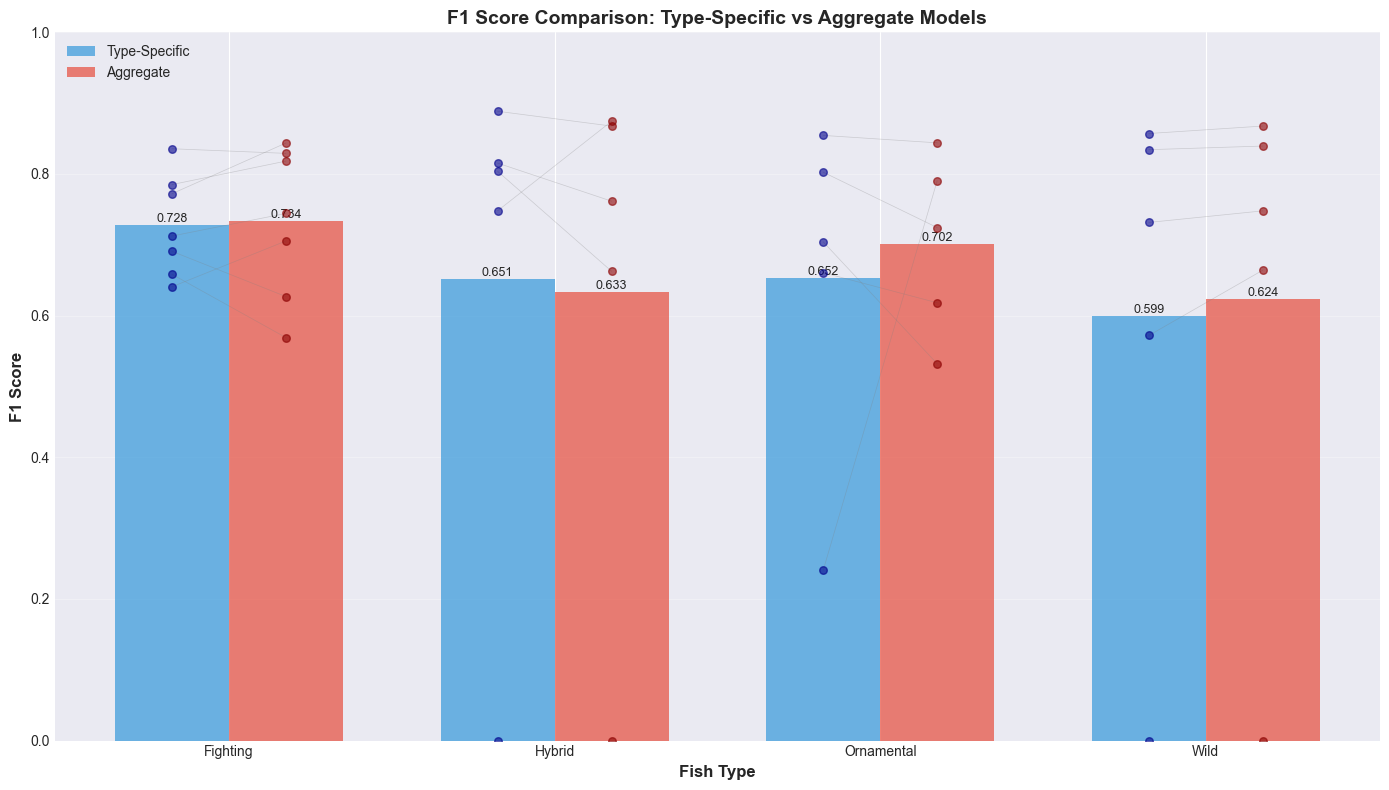

In [21]:
# --- Plot 1: F1 Barplot with Per-Video Points ---

PLOTS_ROOT.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(14, 8))

# Set up bar positions
n_subtypes = len(ALL_SUBTYPES)
bar_width = 0.35
x_positions = np.arange(n_subtypes)
x_subtype = x_positions - bar_width / 2
x_aggregate = x_positions + bar_width / 2

# Colors
subtype_color = '#3498db'  # Blue
aggregate_color = '#e74c3c'  # Red

# Calculate means
subtype_means = []
aggregate_means = []

for idx, subtype in enumerate(ALL_SUBTYPES):
    subtype_data = plot_df[plot_df["subtype"] == subtype]
    
    # Calculate means (using only non-NaN values)
    sub_mean = subtype_data["subtype_f1"].mean()
    agg_mean = subtype_data["aggregate_f1"].mean()
    subtype_means.append(sub_mean)
    aggregate_means.append(agg_mean)

# Plot bars
bars1 = ax.bar(x_subtype, subtype_means, bar_width, label='Type-Specific', color=subtype_color, alpha=0.7)
bars2 = ax.bar(x_aggregate, aggregate_means, bar_width, label='Aggregate', color=aggregate_color, alpha=0.7)

# Plot per-session points and connect lines
for idx, subtype in enumerate(ALL_SUBTYPES):
    subtype_data = plot_df[plot_df["subtype"] == subtype]
    
    # Plot points and connect lines for each session
    for _, row in subtype_data.iterrows():
        sub_f1 = row["subtype_f1"]
        agg_f1 = row["aggregate_f1"]
        
        # Plot points
        if pd.notna(sub_f1):
            ax.scatter(x_subtype[idx], sub_f1, color='darkblue', s=30, alpha=0.6, zorder=5)
        if pd.notna(agg_f1):
            ax.scatter(x_aggregate[idx], agg_f1, color='darkred', s=30, alpha=0.6, zorder=5)
        
        # Connect points if both exist (same session)
        if pd.notna(sub_f1) and pd.notna(agg_f1):
            ax.plot([x_subtype[idx], x_aggregate[idx]], [sub_f1, agg_f1], 
                   'gray', alpha=0.3, linewidth=0.5, zorder=1)

# Customize plot
ax.set_xlabel('Fish Type', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Comparison: Type-Specific vs Aggregate Models', fontsize=14, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels([s.capitalize() for s in ALL_SUBTYPES])
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_ROOT / "f1_comparison_barplot.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved F1 barplot to {PLOTS_ROOT / 'f1_comparison_barplot.png'}")
plt.show()


✓ Saved flaring rate scatterplots to C:\Columbia Capstone\Week 14\hyperparameter_sweep\plots\flaring_rate_scatterplots.png


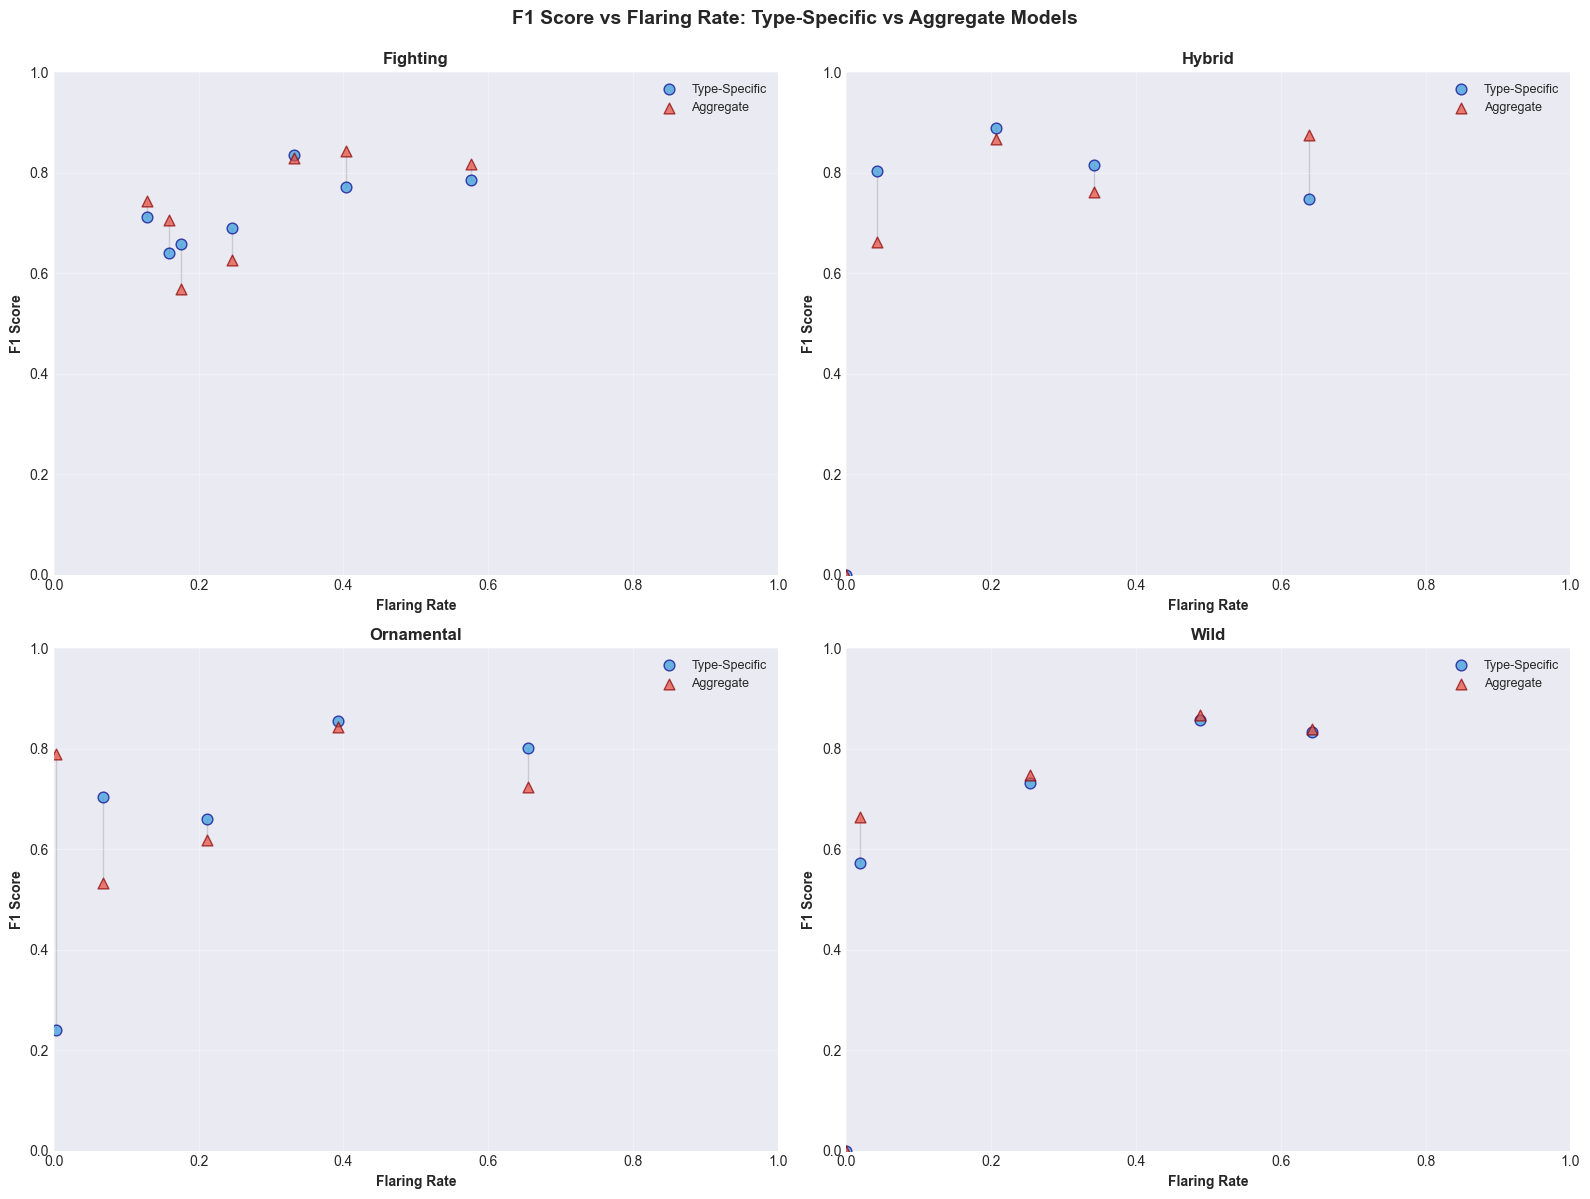

: 

In [ ]:
# --- Plot 2: Flaring Rate Scatterplots (one per fish type) ---

n_subtypes = len(ALL_SUBTYPES)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, subtype in enumerate(ALL_SUBTYPES):
    ax = axes[idx]
    subtype_data = plot_df[plot_df["subtype"] == subtype].copy()
    
    # Filter out rows with missing flare_rate
    subtype_data = subtype_data[subtype_data["flare_rate"].notna()]
    
    if len(subtype_data) == 0:
        ax.text(0.5, 0.5, f'No data for {subtype}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{subtype.capitalize()}', fontsize=12, fontweight='bold')
        continue
    
    # Plot scatter points
    sub_mask = subtype_data["subtype_f1"].notna()
    agg_mask = subtype_data["aggregate_f1"].notna()
    
    if sub_mask.any():
        ax.scatter(subtype_data.loc[sub_mask, "flare_rate"], 
                  subtype_data.loc[sub_mask, "subtype_f1"],
                  label='Type-Specific', color='#3498db', s=60, alpha=0.7, edgecolors='darkblue', linewidth=1)
    
    if agg_mask.any():
        ax.scatter(subtype_data.loc[agg_mask, "flare_rate"], 
                  subtype_data.loc[agg_mask, "aggregate_f1"],
                  label='Aggregate', color='#e74c3c', s=60, alpha=0.7, edgecolors='darkred', linewidth=1, marker='^')
    
    # Connect points for same session
    for _, row in subtype_data.iterrows():
        if pd.notna(row["subtype_f1"]) and pd.notna(row["aggregate_f1"]):
            ax.plot([row["flare_rate"], row["flare_rate"]], 
                   [row["subtype_f1"], row["aggregate_f1"]],
                   'gray', alpha=0.3, linewidth=1, zorder=0)
    
    # Customize subplot
    ax.set_xlabel('Flaring Rate', fontsize=10, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=10, fontweight='bold')
    ax.set_title(f'{subtype.capitalize()}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])

plt.suptitle('F1 Score vs Flaring Rate: Type-Specific vs Aggregate Models', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(PLOTS_ROOT / "flaring_rate_scatterplots.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved flaring rate scatterplots to {PLOTS_ROOT / 'flaring_rate_scatterplots.png'}")
plt.show()


## Visualization v2 (per mentor request)

- Set **zero flare-rate** sessions to **NaN** (excluded from F1 means/points)
- Select **one single aggregate model** by taking the mean F1 across the 4 fish types (evenly weighted)
- Replot using that single aggregate model


In [3]:
# --- Visualization v2: choose single aggregate model + set zero-flare sessions to NaN ---

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _read_json(path: Path) -> dict:
    if not path.exists():
        return {}
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def _best_hparam_key(hparam_results: dict) -> str | None:
    if not hparam_results:
        return None
    best_key = None
    best_f1 = -1e18
    for k, v in hparam_results.items():
        f1 = v.get("test_f1", None)
        if f1 is None:
            continue
        if f1 > best_f1:
            best_f1 = f1
            best_key = k
    return best_key


def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan


def calculate_flaring_rate(subtype: str, session: str) -> float | None:
    """Flaring rate = fraction of frames labeled as flare in the 2-class labels."""
    labels_dir = (BINARY_DATA_ROOT / subtype / VARIANT) / "labels"
    label_file = _find_label_file(labels_dir, session, subtype)

    if label_file is None:
        return None

    df = pd.read_csv(label_file)
    if "flare" in df.columns:
        return float((df["flare"] > 0).mean())
    if {"background", "flare"}.issubset(df.columns):
        return float((df["flare"] > df["background"]).mean())
    return float((df.iloc[:, -1] > 0).mean())


# ---- Fallbacks (in case kernel restarted and earlier config cells weren't run) ----
PROJECT_ROOT = globals().get("PROJECT_ROOT", Path("C:/Columbia Capstone"))
WEEK14_ROOT = globals().get("WEEK14_ROOT", PROJECT_ROOT / "Week 14")
HPARAM_ROOT = globals().get("HPARAM_ROOT", WEEK14_ROOT / "hyperparameter_sweep")

RESULTS_ROOT = globals().get("RESULTS_ROOT", HPARAM_ROOT / "results")
PLOTS_ROOT = globals().get("PLOTS_ROOT", HPARAM_ROOT / "plots")
BINARY_DATA_ROOT = globals().get("BINARY_DATA_ROOT", HPARAM_ROOT / "binary_data")

VARIANT = globals().get("VARIANT", "LP_with_cal_contour")
ALL_SUBTYPES = globals().get("ALL_SUBTYPES", ["fighting", "hybrid", "ornamental", "wild"])

PLOTS_ROOT.mkdir(parents=True, exist_ok=True)


def _find_label_file(labels_dir: Path, session: str, subtype: str) -> Path | None:
    candidates = [labels_dir / f"{session}.csv"]

    # common alias: ornamental uses "oR" suffix in some places
    if subtype == "ornamental" and session.endswith("oR"):
        candidates.append(labels_dir / f"{session[:-2]}R.csv")

    for p in candidates:
        if p.exists():
            return p

    # fallback: prefix match (matches e.g. session_labels.csv)
    matches = list(labels_dir.glob(f"{session}*.csv"))
    return matches[0] if matches else None


# Load results
results_dir = RESULTS_ROOT
subtype_results = {
    st: _read_json(results_dir / f"{st}_results.json").get("hparam_results", {})
    for st in ALL_SUBTYPES
}
aggregate_results = _read_json(results_dir / "aggregate_results.json").get("subtype_results", {})

# Best subtype-specific model per fish type (as before)
best_subtype_key = {st: _best_hparam_key(subtype_results[st]) for st in ALL_SUBTYPES}

# Choose ONE aggregate model globally: mean across fish types (evenly weighted)
agg_keys_sets = []
for st in ALL_SUBTYPES:
    st_dict = aggregate_results.get(st, {})
    agg_keys_sets.append(set(st_dict.keys()))

common_agg_keys = set.intersection(*agg_keys_sets) if agg_keys_sets else set()
if not common_agg_keys:
    raise RuntimeError("No common aggregate hparam keys found across all fish types.")

agg_key_to_mean = {}
for k in sorted(common_agg_keys):
    f1s = []
    ok = True
    for st in ALL_SUBTYPES:
        v = aggregate_results.get(st, {}).get(k, {})
        f1 = v.get("test_f1", None)
        if f1 is None:
            ok = False
            break
        f1s.append(_safe_float(f1))
    if ok and all(np.isfinite(f1s)):
        agg_key_to_mean[k] = float(np.mean(f1s))

if not agg_key_to_mean:
    raise RuntimeError("Could not compute mean F1 for any aggregate model across fish types.")

global_aggregate_key = max(agg_key_to_mean, key=lambda kk: agg_key_to_mean[kk])

print("Selected models:")
for st in ALL_SUBTYPES:
    print(f"  {st}: subtype_best={best_subtype_key[st]}")
print(f"  aggregate_single_best={global_aggregate_key} (mean across fish types={agg_key_to_mean[global_aggregate_key]:.4f})")


# Build plotting dataframe
rows = []
EPS = 1e-12

for st in ALL_SUBTYPES:
    sub_key = best_subtype_key[st]
    sub_per = (subtype_results.get(st, {}).get(sub_key, {}) if sub_key else {}).get("per_session_f1", {})

    agg_per = (
        aggregate_results.get(st, {}).get(global_aggregate_key, {}).get("per_session_f1", {})
    )

    sessions = set(sub_per.keys()) | set(agg_per.keys())

    for session in sessions:
        flare_rate = calculate_flaring_rate(st, session)
        sub_f1 = sub_per.get(session, np.nan)
        agg_f1 = agg_per.get(session, np.nan)

        # If flare_rate is zero → set F1 to NaN (excluded from barplot & points)
        if flare_rate is not None and flare_rate <= EPS:
            sub_f1 = np.nan
            agg_f1 = np.nan

        rows.append(
            {
                "subtype": st,
                "session": session,
                "flare_rate": flare_rate,
                "subtype_f1": _safe_float(sub_f1),
                "aggregate_f1": _safe_float(agg_f1),
            }
        )

plot_df_v2 = pd.DataFrame(rows)

# Drop rows where both are NaN
plot_df_v2 = plot_df_v2[plot_df_v2["subtype_f1"].notna() | plot_df_v2["aggregate_f1"].notna()].copy()

print("\nCounts (after excluding zero-flare sessions):")
print(plot_df_v2.groupby("subtype")[["subtype_f1", "aggregate_f1"]].count())


Selected models:
  fighting: subtype_best=nh64_ly3_lg8_lr5e-04
  hybrid: subtype_best=nh32_ly3_lg8_lr5e-04
  ornamental: subtype_best=nh32_ly3_lg4_lr1e-04
  wild: subtype_best=nh64_ly2_lg8_lr1e-04
  aggregate_single_best=nh64_ly3_lg8_lr5e-04 (mean across fish types=0.6594)

Counts (after excluding zero-flare sessions):
            subtype_f1  aggregate_f1
subtype                             
fighting             7             7
hybrid               4             4
ornamental           5             5
wild                 4             4


✓ Saved: C:\Columbia Capstone\Week 14\hyperparameter_sweep\plots\f1_comparison_barplot_v2_single_agg_zero_flare_nan.png


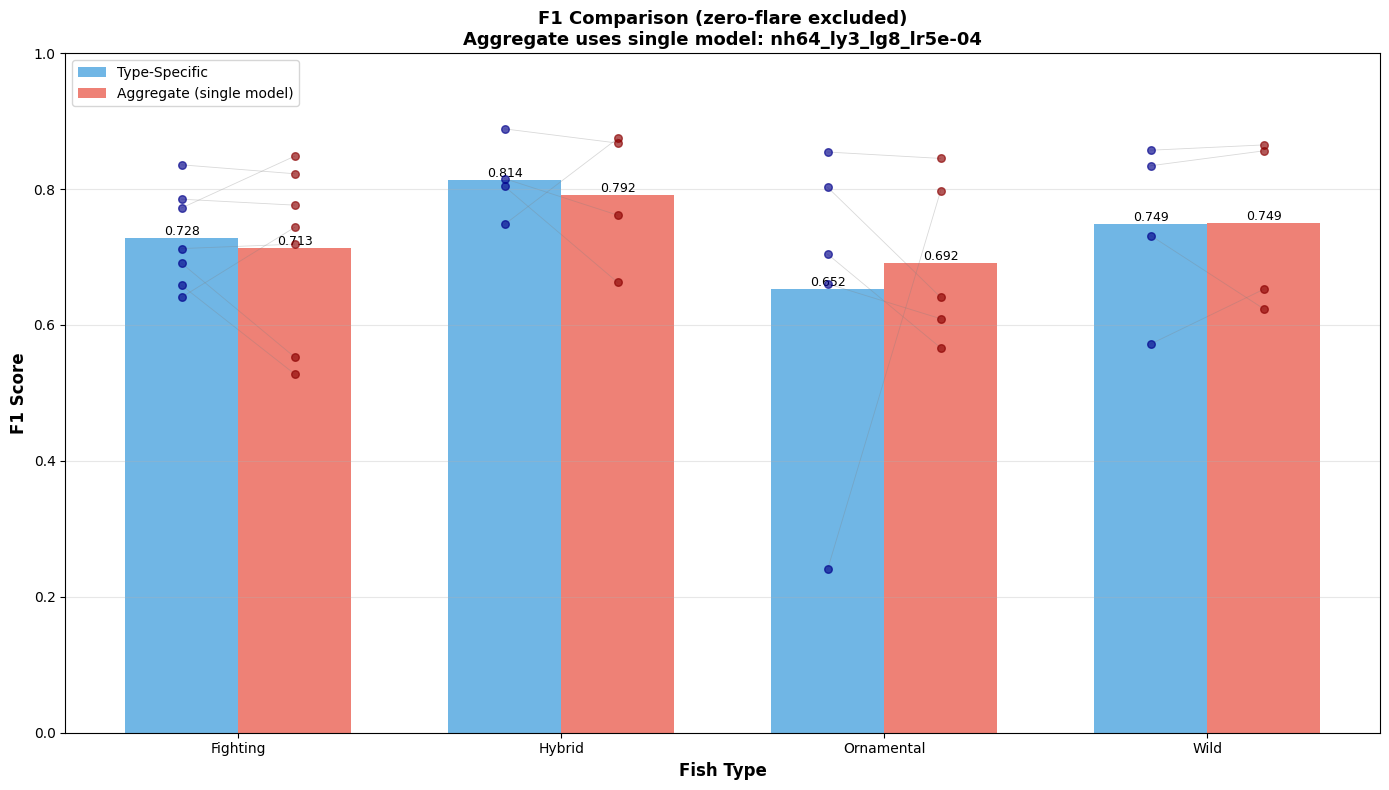

In [4]:
# --- Plot v2: F1 barplot (zero-flare excluded) + single aggregate model ---

PLOTS_ROOT.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35
x_positions = np.arange(len(ALL_SUBTYPES))
x_subtype = x_positions - bar_width / 2
x_aggregate = x_positions + bar_width / 2

subtype_color = "#3498db"
aggregate_color = "#e74c3c"

subtype_means = []
aggregate_means = []

for st in ALL_SUBTYPES:
    d = plot_df_v2[plot_df_v2["subtype"] == st]
    subtype_means.append(float(d["subtype_f1"].mean()))
    aggregate_means.append(float(d["aggregate_f1"].mean()))

bars1 = ax.bar(x_subtype, subtype_means, bar_width, label="Type-Specific", color=subtype_color, alpha=0.7)
bars2 = ax.bar(x_aggregate, aggregate_means, bar_width, label="Aggregate (single model)", color=aggregate_color, alpha=0.7)

# points + connecting lines per session
for idx, st in enumerate(ALL_SUBTYPES):
    d = plot_df_v2[plot_df_v2["subtype"] == st]
    for _, row in d.iterrows():
        sub_f1 = row["subtype_f1"]
        agg_f1 = row["aggregate_f1"]
        if pd.notna(sub_f1):
            ax.scatter(x_subtype[idx], sub_f1, color="darkblue", s=30, alpha=0.65, zorder=5)
        if pd.notna(agg_f1):
            ax.scatter(x_aggregate[idx], agg_f1, color="darkred", s=30, alpha=0.65, zorder=5)
        if pd.notna(sub_f1) and pd.notna(agg_f1):
            ax.plot([x_subtype[idx], x_aggregate[idx]], [sub_f1, agg_f1], color="gray", alpha=0.3, linewidth=0.6, zorder=1)

ax.set_xlabel("Fish Type", fontsize=12, fontweight="bold")
ax.set_ylabel("F1 Score", fontsize=12, fontweight="bold")
ax.set_title(
    f"F1 Comparison (zero-flare excluded)\nAggregate uses single model: {global_aggregate_key}",
    fontsize=13,
    fontweight="bold",
)
ax.set_xticks(x_positions)
ax.set_xticklabels([s.capitalize() for s in ALL_SUBTYPES])
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis="y")
ax.legend(loc="upper left")

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        if np.isfinite(h):
            ax.text(bar.get_x() + bar.get_width() / 2.0, h, f"{h:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
out_path = PLOTS_ROOT / "f1_comparison_barplot_v2_single_agg_zero_flare_nan.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✓ Saved: {out_path}")
plt.show()


✓ Saved: C:\Columbia Capstone\Week 14\hyperparameter_sweep\plots\flaring_rate_scatterplots_v2_single_agg_zero_flare_nan.png


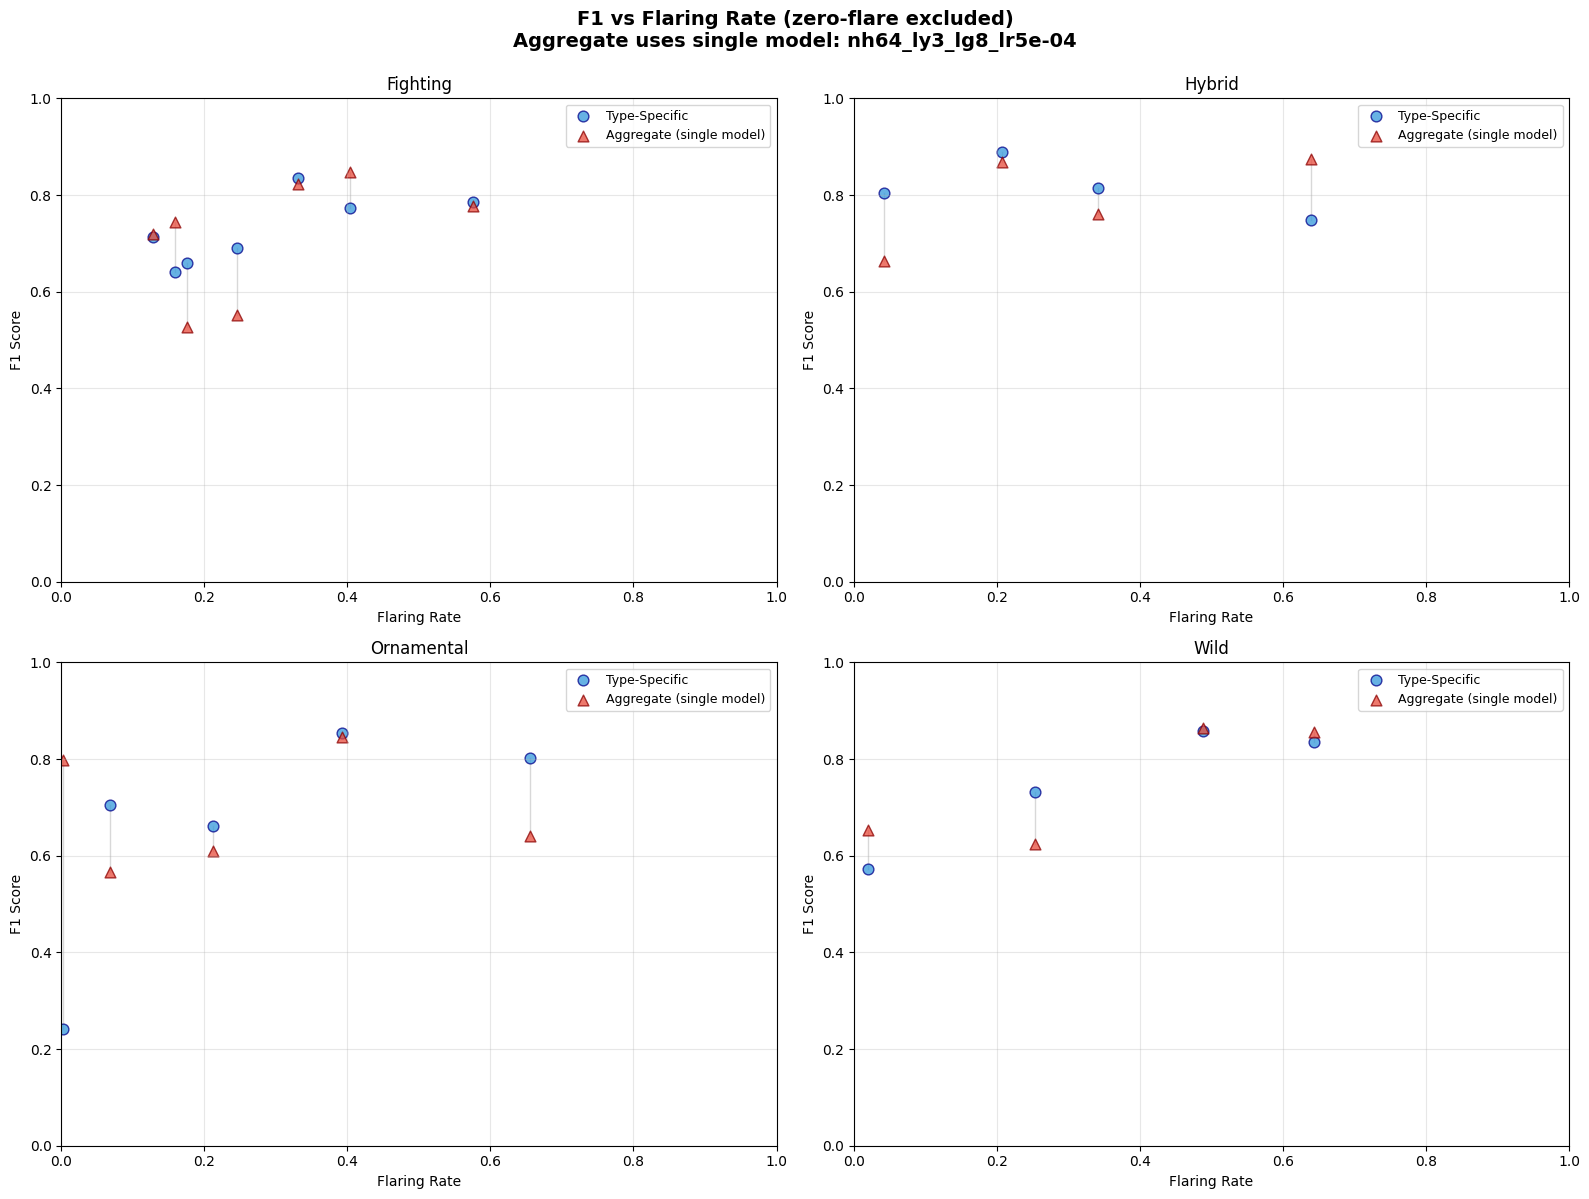

In [5]:
# --- Plot v2: F1 vs flaring-rate scatterplots (zero-flare excluded) ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, st in enumerate(ALL_SUBTYPES):
    ax = axes[idx]
    d = plot_df_v2[plot_df_v2["subtype"] == st].copy()
    d = d[d["flare_rate"].notna()]

    if d.empty:
        ax.text(0.5, 0.5, f"No data for {st}", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(st.capitalize())
        continue

    sub_mask = d["subtype_f1"].notna()
    agg_mask = d["aggregate_f1"].notna()

    if sub_mask.any():
        ax.scatter(
            d.loc[sub_mask, "flare_rate"],
            d.loc[sub_mask, "subtype_f1"],
            label="Type-Specific",
            color="#3498db",
            s=60,
            alpha=0.75,
            edgecolors="darkblue",
            linewidth=1,
        )

    if agg_mask.any():
        ax.scatter(
            d.loc[agg_mask, "flare_rate"],
            d.loc[agg_mask, "aggregate_f1"],
            label="Aggregate (single model)",
            color="#e74c3c",
            s=60,
            alpha=0.75,
            edgecolors="darkred",
            linewidth=1,
            marker="^",
        )

    # connect same session
    for _, row in d.iterrows():
        if pd.notna(row["subtype_f1"]) and pd.notna(row["aggregate_f1"]):
            ax.plot(
                [row["flare_rate"], row["flare_rate"]],
                [row["subtype_f1"], row["aggregate_f1"]],
                color="gray",
                alpha=0.3,
                linewidth=1,
                zorder=0,
            )

    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Flaring Rate")
    ax.set_ylabel("F1 Score")
    ax.set_title(st.capitalize())
    ax.legend(loc="best", fontsize=9)

plt.suptitle(
    f"F1 vs Flaring Rate (zero-flare excluded)\nAggregate uses single model: {global_aggregate_key}",
    fontsize=14,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
out_path = PLOTS_ROOT / "flaring_rate_scatterplots_v2_single_agg_zero_flare_nan.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✓ Saved: {out_path}")
plt.show()


## Final Aggregate Training (ALL data)

Train the final aggregate model using **all sessions** (train + test + val across all subtypes) with the selected best aggregate hyperparameters:

- `num_hid_units=64`
- `num_layers=3`
- `num_lags=8`
- `lr=5e-4`

Outputs are saved to:
- `Week 14/hyperparameter_sweep/models/aggregate/<hparam_key>__all_data_final/`
- `Week 14/deliverables/models/aggregate_all_data/<hparam_key>/` (minimal copy for packaging)


In [6]:
# --- Train final aggregate model on ALL data and copy artifacts into deliverables/ ---

from __future__ import annotations

import json
import shutil
from pathlib import Path

import yaml
from lightning_action.api import Model


def _find_repo_root() -> Path:
    """Find repo root by locating 'Week 14/hyperparameter_sweep'."""
    for base in [Path.cwd(), Path.cwd().resolve()]:
        for p in [base] + list(base.parents):
            if (p / "Week 14" / "hyperparameter_sweep").exists():
                return p
    return Path.cwd().resolve()


def _parse_splits(path: Path) -> dict[str, list[str]]:
    current = None
    splits: dict[str, list[str]] = {"train": [], "test": [], "val": []}
    for raw_line in path.read_text(encoding="utf-8").splitlines():
        line = raw_line.split("#", 1)[0].strip()
        if not line:
            continue
        if line.endswith(":"):
            key = line[:-1].strip()
            current = key if key in splits else None
            continue
        if current and line.startswith("-"):
            value = line[1:].strip()
            if value:
                splits[current].append(value)
    return splits


# --- Config ---
REPO_ROOT = _find_repo_root()
WEEK14_ROOT = REPO_ROOT / "Week 14"
SWEEP_ROOT = WEEK14_ROOT / "hyperparameter_sweep"

VARIANT = "LP_with_cal_contour"
HPARAM_KEY = "nh64_ly3_lg8_lr5e-04"

NUM_HID_UNITS = 64
NUM_LAYERS = 3
NUM_LAGS = 8
LR = 5e-4
NUM_EPOCHS = 400

INPUT_SIZE = 18
OUTPUT_SIZE = 2
SEED = 43

DATA_PATH = SWEEP_ROOT / "binary_data" / "aggregate" / VARIANT
SPLITS = _parse_splits(DATA_PATH / "splits.yaml")
EXPT_IDS = SPLITS["train"] + SPLITS["test"] + SPLITS.get("val", [])

OUT_DIR = SWEEP_ROOT / "models" / "aggregate" / f"{HPARAM_KEY}__all_data_final"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Build lightning-action config (do not set training.sequence_pad)
config = {
    "data": {
        "data_path": str(DATA_PATH),
        "input_dir": "features",
        "transforms": ["ZScore"],
        "expt_ids": EXPT_IDS,
        "seed": SEED,
        "ignore_index": -100,
        "weight_classes": True,
        "label_names": ["background", "flare"],
    },
    "model": {
        "backbone": "dtcn",
        "input_size": INPUT_SIZE,
        "output_size": OUTPUT_SIZE,
        "num_hid_units": NUM_HID_UNITS,
        "num_layers": NUM_LAYERS,
        "num_lags": NUM_LAGS,
        "seed": SEED,
    },
    "optimizer": {
        "type": "Adam",
        "lr": LR,
        "wd": 0,
        "scheduler": None,
    },
    "training": {
        "device": "gpu",
        "num_epochs": NUM_EPOCHS,
        "batch_size": 16,
        "num_workers": 4,
        "sequence_length": 1000,
        "train_probability": 0.95,
        "val_probability": 0.05,
    },
}

# Save config.yaml for reproducibility
with open(OUT_DIR / "config.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(config, f, sort_keys=False)

print("=" * 80)
print("FINAL AGGREGATE TRAINING (ALL DATA)")
print(f"Repo root: {REPO_ROOT}")
print(f"Data: {DATA_PATH}")
print(f"Sessions (all): {len(EXPT_IDS)}")
print(f"Hyperparams: {HPARAM_KEY} (nh=64, ly=3, lg=8, lr=5e-4)")
print(f"Output: {OUT_DIR}")
print("=" * 80)

# Train
model = Model.from_config(config)
# post_inference=False to avoid generating predictions for all 77 sessions during training
model.train(output_dir=OUT_DIR, post_inference=False)

# Copy minimal artifacts into deliverables/
DELIV_DIR = WEEK14_ROOT / "deliverables" / "models" / "aggregate_all_data" / HPARAM_KEY
DELIV_DIR.mkdir(parents=True, exist_ok=True)

# Always copy config
shutil.copy2(OUT_DIR / "config.yaml", DELIV_DIR / "config.yaml")

# Copy final_model.ckpt if present; otherwise copy best checkpoint if available
final_ckpt = OUT_DIR / "final_model.ckpt"
if final_ckpt.exists():
    shutil.copy2(final_ckpt, DELIV_DIR / "final_model.ckpt")
else:
    ckpts = list((OUT_DIR / "tb_logs").rglob("*.ckpt"))
    if ckpts:
        shutil.copy2(ckpts[0], DELIV_DIR / ckpts[0].name)

# Write a small pointer JSON as well
pointer = {
    "hparam_key": HPARAM_KEY,
    "variant": VARIANT,
    "train_split": "all (train+test+val)",
    "data_path": str(DATA_PATH),
    "model_dir": str(OUT_DIR),
    "deliverables_copy": str(DELIV_DIR),
}
with open(DELIV_DIR / "MODEL_POINTER.json", "w", encoding="utf-8") as f:
    json.dump(pointer, f, indent=2)

print(f"\n✓ Deliverables copy saved to: {DELIV_DIR}")
print("Done.")


Seed set to 43


FINAL AGGREGATE TRAINING (ALL DATA)
Repo root: c:\Columbia Capstone
Data: c:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
Sessions (all): 77
Hyperparams: nh64_ly3_lg8_lr5e-04 (nh=64, ly=3, lg=8, lr=5e-4)
Output: c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final
Output directory: c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final
Model type: <class 'lightning_action.models.segmenter.Segmenter'>
Configuration:
--------------------
data parameters
--------------------
data_path: c:\Columbia Capstone\Week 14\hyperparameter_sweep\binary_data\aggregate\LP_with_cal_contour
input_dir: features
transforms: ['ZScore']
expt_ids: ['fighting__1.1.28R', 'fighting__1.1.28L', 'fighting__1.2.2R', 'fighting__1.2.28R', 'fighting__1.3.1R', 'fighting__1.4.1R', 'fighting__2.1.28L', 'fighting__3.1.28L', 'fighting__3.2.28L', 'hybrid__RHT3.3.1R', 'hybrid__RHT4.3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | train_f1       | MulticlassF1Score  | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | val_f1         | MulticlassF1Score  | 0      | train
4 | backbone       | DilatedTCN         | 369 K  | train
5 | classifier     | Linear             | 130    | train
---------

Epoch 399: 100%|██████████| 156/156 [00:09<00:00, 16.00it/s, val_loss=0.475, val_accuracy=0.931, val_f1=0.931, train_loss=0.0596, train_accuracy=0.975, train_f1=0.975]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 156/156 [00:09<00:00, 15.99it/s, val_loss=0.475, val_accuracy=0.931, val_f1=0.931, train_loss=0.0596, train_accuracy=0.975, train_f1=0.975]

✓ Deliverables copy saved to: c:\Columbia Capstone\Week 14\deliverables\models\aggregate_all_data\nh64_ly3_lg8_lr5e-04
Done.


## Final Aggregate Model — True vs Predicted Flare Rate (ALL sessions)

This plot uses the **final aggregate model** trained on **all sessions** and compares:
- **x-axis**: ground-truth flare rate (from labels)
- **y-axis**: predicted flare rate (from model predictions)

It is shown **split by fish type** (fighting / hybrid / ornamental / wild) over **all 77 sessions**.


Seed set to 43


Missing 77 prediction files. Running inference now...


Seed set to 43


Loaded model weights from c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\tb_logs\checkpoints\epoch=68-step=10764-best.ckpt
Generating predictions for experiment: fighting__1.1.28R


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.1.28R_predictions.csv
Generating predictions for experiment: fighting__1.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.1.28L_predictions.csv
Generating predictions for experiment: fighting__1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.2.2R_predictions.csv
Generating predictions for experiment: fighting__1.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.2.28R_predictions.csv
Generating predictions for experiment: fighting__1.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.3.1R_predictions.csv
Generating predictions for experiment: fighting__1.4.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.4.1R_predictions.csv
Generating predictions for experiment: fighting__2.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__2.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.1.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__3.1.28L_predictions.csv
Generating predictions for experiment: fighting__3.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__3.2.28L_predictions.csv
Generating predictions for experiment: hybrid__RHT3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT5.10.1R_predictions.csv
Generating predictions for experiment: hybrid__RHT6.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT6.2.2L_predictions.csv
Generating predictions for experiment: hybrid__RHT2.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT2.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT9.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT9.8.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf1.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf1.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf1.5.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf2.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf2.10.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf3.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf3.3.1R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf4.3.1L_predictions.csv
Generating predictions for experiment: hybrid__wxf5180R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf5180R_predictions.csv
Generating predictions for experiment: hybrid__wxf5239R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf5239R_predictions.csv
Generating predictions for experiment: hybrid__wxf5272L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf5272L_predictions.csv
Generating predictions for experiment: ornamental__1.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__1.9.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__2.7.1R_predictions.csv
Generating predictions for experiment: ornamental__2.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__2.7.2R_predictions.csv
Generating predictions for experiment: ornamental__2.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__2.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.7.1R_predictions.csv
Generating predictions for experiment: ornamental__3.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.7.2R_predictions.csv
Generating predictions for experiment: ornamental__3.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.9.1R_predictions.csv
Generating predictions for experiment: ornamental__3.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.9.2R_predictions.csv
Generating predictions for experiment: ornamental__5.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__5.10.1R_predictions.csv
Generating predictions for experiment: ornamental__5.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__5.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.10.1R_predictions.csv
Generating predictions for experiment: ornamental__6.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.5.2R_predictions.csv
Generating predictions for experiment: ornamental__6.7.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.7.2R_predictions.csv
Generating predictions for experiment: ornamental__6.8.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.8.2R_predictions.csv
Generating predictions for experiment: ornamental__6.9.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.9.1R_predictions.csv
Generating predictions for experiment: ornamental__6.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.9.2R_predictions.csv
Generating predictions for experiment: wild__1.10.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1.10.1R_predictions.csv
Generating predictions for experiment: wild__1.9.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1.9.2R_predictions.csv
Generating predictions for experiment: wild__1381.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1381.1_predictions.csv
Generating predictions for experiment: wild__1384.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1384.2_predictions.csv
Generating predictions for experiment: wild__1434.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1434.1_predictions.csv
Generating predictions for experiment: wild__1434.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1434.2_predictions.csv
Generating predictions for experiment: wild__1436.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1436.1_predictions.csv
Generating predictions for experiment: wild__1436.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1436.2_predictions.csv
Generating predictions for experiment: wild__1437.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1437.1_predictions.csv
Generating predictions for experiment: wild__1437.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1437.2_predictions.csv
Generating predictions for experiment: wild__1438.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1438.1_predictions.csv
Generating predictions for experiment: wild__1508.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1508.1_predictions.csv
Generating predictions for experiment: wild__2.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__2.6.1R_predictions.csv
Generating predictions for experiment: wild__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__3.5.1R_predictions.csv
Generating predictions for experiment: fighting__1.2.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.2.2L_predictions.csv
Generating predictions for experiment: fighting__1.2.28L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.2.28L_predictions.csv
Generating predictions for experiment: fighting__1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.3.1L_predictions.csv
Generating predictions for experiment: fighting__1.4.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__1.4.1L_predictions.csv
Generating predictions for experiment: fighting__2.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__2.1.28R_predictions.csv
Generating predictions for experiment: fighting__3.1.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__3.1.28R_predictions.csv
Generating predictions for experiment: fighting__3.2.28R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\fighting__3.2.28R_predictions.csv
Generating predictions for experiment: hybrid__RHT2.5.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT2.5.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf1.3.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf1.3.2R_predictions.csv
Generating predictions for experiment: hybrid__RHT1.3.1L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT1.3.1L_predictions.csv
Generating predictions for experiment: hybrid__RHT5.2.2R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__RHT5.2.2R_predictions.csv
Generating predictions for experiment: hybrid__wxf4.3.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\hybrid__wxf4.3.1R_predictions.csv
Generating predictions for experiment: ornamental__6.6.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.6.1R_predictions.csv
Generating predictions for experiment: ornamental__1.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__1.8.2L_predictions.csv
Generating predictions for experiment: ornamental__3.8.2L


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.8.2L_predictions.csv
Generating predictions for experiment: ornamental__6.8.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__6.8.1R_predictions.csv
Generating predictions for experiment: ornamental__3.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\ornamental__3.5.1R_predictions.csv
Generating predictions for experiment: wild__1385.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1385.1_predictions.csv
Generating predictions for experiment: wild__2.7.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__2.7.1R_predictions.csv
Generating predictions for experiment: wild__4.5.1R


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__4.5.1R_predictions.csv
Generating predictions for experiment: wild__1381.2


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1381.2_predictions.csv
Generating predictions for experiment: wild__1384.1


c:\Users\12618\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Saved predictions to c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions\wild__1384.1_predictions.csv
Completed predictions for 77 experiments in c:\Columbia Capstone\Week 14\hyperparameter_sweep\models\aggregate\nh64_ly3_lg8_lr5e-04__all_data_final\predictions_all_sessions
           true_flare_rate                                                    \
                     count      mean       std       min       25%       50%   
fish_type                                                                      
fighting              16.0  0.246905  0.219722  0.002319  0.108892  0.193583   
hybrid                20.0  0.165994  0.207262  0.000000  0.000875  0.084667   
ornamental            22.0  0.311983  0.204019  0.003000  0.103510  0.347958   
wild                  19.0  0.130237  0.199314  0.000000  0.000000  0.019208   

                               pred_flare_rate                                \
       

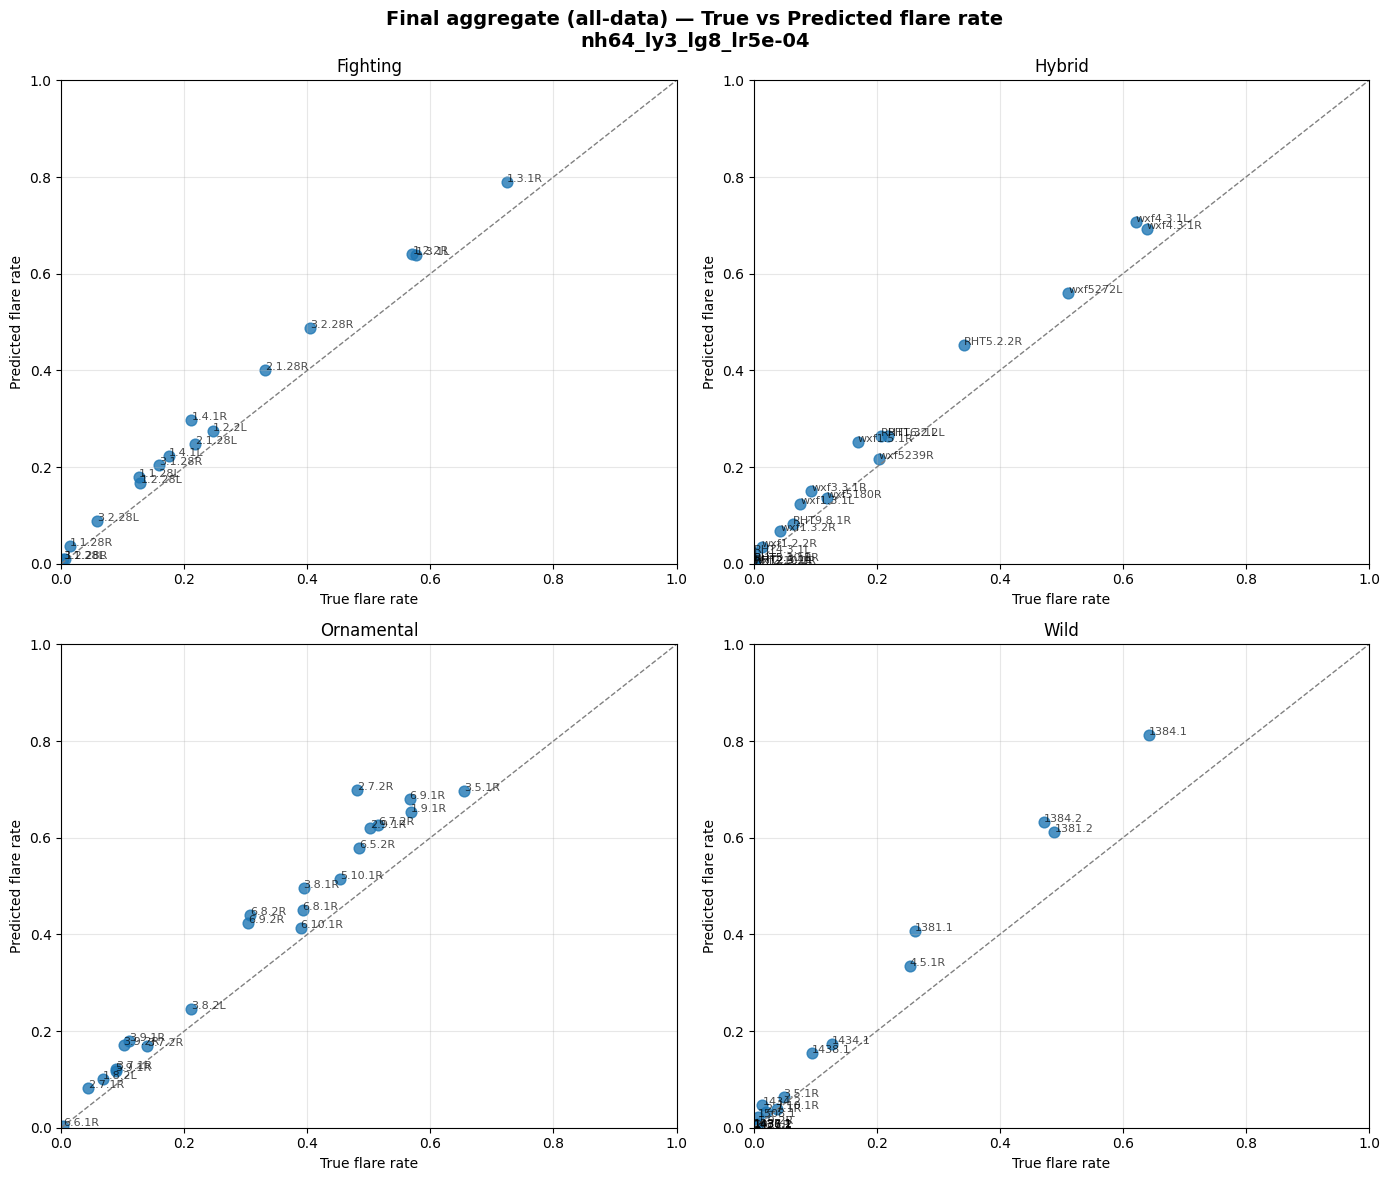


✓ Saved plot: c:\Columbia Capstone\Week 14\hyperparameter_sweep\plots\final_aggregate_all_data_true_vs_pred_flare_rate__nh64_ly3_lg8_lr5e-04.png
✓ Copied to: c:\Columbia Capstone\Week 14\deliverables\plots\final_aggregate_all_data\final_aggregate_all_data_true_vs_pred_flare_rate__nh64_ly3_lg8_lr5e-04.png


In [7]:
# --- Scatterplots: True vs Predicted flare rate for FINAL aggregate (all sessions) ---

from __future__ import annotations

import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightning_action.api import Model


def _find_repo_root() -> Path:
    for base in [Path.cwd(), Path.cwd().resolve()]:
        for p in [base] + list(base.parents):
            if (p / "Week 14" / "hyperparameter_sweep").exists():
                return p
    return Path.cwd().resolve()


def _parse_splits(path: Path) -> dict[str, list[str]]:
    current = None
    splits: dict[str, list[str]] = {"train": [], "test": [], "val": []}
    for raw_line in path.read_text(encoding="utf-8").splitlines():
        line = raw_line.split("#", 1)[0].strip()
        if not line:
            continue
        if line.endswith(":"):
            key = line[:-1].strip()
            current = key if key in splits else None
            continue
        if current and line.startswith("-"):
            value = line[1:].strip()
            if value:
                splits[current].append(value)
    return splits


def _true_flare_rate(label_file: Path) -> float:
    df = pd.read_csv(label_file)
    if "flare" in df.columns:
        return float((df["flare"] > 0).mean())
    if {"background", "flare"}.issubset(df.columns):
        return float((df["flare"] > df["background"]).mean())
    return float((df.iloc[:, -1] > 0).mean())


def _pred_flare_rate(pred_file: Path) -> float:
    df = pd.read_csv(pred_file)
    if {"background", "flare"}.issubset(df.columns):
        preds = np.argmax(df[["background", "flare"]].values, axis=1)
        return float(preds.mean())
    if "predicted" in df.columns:
        vals = df["predicted"].values
        # treat >0 as flare
        return float((vals > 0).mean())
    if "flare" in df.columns:
        # probability threshold
        return float((df["flare"] > 0.5).mean())
    return float((df.iloc[:, -1] > 0).mean())


REPO_ROOT = _find_repo_root()
WEEK14_ROOT = REPO_ROOT / "Week 14"
SWEEP_ROOT = WEEK14_ROOT / "hyperparameter_sweep"
PLOTS_ROOT = SWEEP_ROOT / "plots"
PLOTS_ROOT.mkdir(parents=True, exist_ok=True)

DELIV_PLOTS = WEEK14_ROOT / "deliverables" / "plots" / "final_aggregate_all_data"
DELIV_PLOTS.mkdir(parents=True, exist_ok=True)

VARIANT = "LP_with_cal_contour"
HPARAM_KEY = "nh64_ly3_lg8_lr5e-04"

DATA_PATH = SWEEP_ROOT / "binary_data" / "aggregate" / VARIANT
splits = _parse_splits(DATA_PATH / "splits.yaml")
expt_ids = splits["train"] + splits["test"] + splits.get("val", [])

MODEL_DIR = SWEEP_ROOT / "models" / "aggregate" / f"{HPARAM_KEY}__all_data_final"
if not MODEL_DIR.exists():
    raise FileNotFoundError(f"Final model dir not found: {MODEL_DIR}")

# Predictions for ALL sessions
PRED_DIR = MODEL_DIR / "predictions_all_sessions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

missing = [eid for eid in expt_ids if not (PRED_DIR / f"{eid}_predictions.csv").exists()]
if missing:
    print(f"Missing {len(missing)} prediction files. Running inference now...")
    model = Model.from_dir(MODEL_DIR)
    model.predict(
        data_path=str(DATA_PATH),
        input_dir="features",
        output_dir=str(PRED_DIR),
        expt_ids=missing,
    )
else:
    print("All prediction files already exist.")

# Compute true vs predicted flare rate
rows = []
labels_dir = DATA_PATH / "labels"

for eid in expt_ids:
    label_file = labels_dir / f"{eid}.csv"
    pred_file = PRED_DIR / f"{eid}_predictions.csv"
    if not label_file.exists() or not pred_file.exists():
        continue

    fish_type = eid.split("__", 1)[0] if "__" in eid else "unknown"
    session = eid.split("__", 1)[1] if "__" in eid else eid

    rows.append(
        {
            "fish_type": fish_type,
            "session": session,
            "expt_id": eid,
            "true_flare_rate": _true_flare_rate(label_file),
            "pred_flare_rate": _pred_flare_rate(pred_file),
        }
    )

rate_df = pd.DataFrame(rows)
print(rate_df.groupby("fish_type")[["true_flare_rate", "pred_flare_rate"]].describe())

# Plot: split by fish type
fish_types = ["fighting", "hybrid", "ornamental", "wild"]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, ft in enumerate(fish_types):
    ax = axes[i]
    d = rate_df[rate_df["fish_type"] == ft]
    ax.scatter(d["true_flare_rate"], d["pred_flare_rate"], s=60, alpha=0.8)

    # y=x reference
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

    # labels
    for _, r in d.iterrows():
        ax.annotate(r["session"], (r["true_flare_rate"], r["pred_flare_rate"]), fontsize=8, alpha=0.7)

    ax.set_title(ft.capitalize())
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("True flare rate")
    ax.set_ylabel("Predicted flare rate")
    ax.grid(True, alpha=0.3)

plt.suptitle(
    f"Final aggregate (all-data) — True vs Predicted flare rate\n{HPARAM_KEY}",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()

out_png = PLOTS_ROOT / f"final_aggregate_all_data_true_vs_pred_flare_rate__{HPARAM_KEY}.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

# Copy to deliverables
shutil.copy2(out_png, DELIV_PLOTS / out_png.name)
print(f"\n✓ Saved plot: {out_png}")
print(f"✓ Copied to: {DELIV_PLOTS / out_png.name}")
